# Credit Application Classification

Environment used = AWS EMR 2 Node cluster with m4.large instances, 1 Master and 1 Core


In [1]:
%%info

#Below lines are for running Pyspark on AWS EC2 system configuration

import os
import sys
os.environ["PYSPARK_PYTHON"]="/home/ec2-user/spark-2.4.4-bin-hadoop2.7/python"
os.environ["JAVA_HOME"] = "/usr/java/jdk1.8.0_161/jre"
os.environ["SPARK_HOME"] = "/home/ec2-user/spark-2.4.4-bin-hadoop2.7"
os.environ["PYLIB"] = os.environ["SPARK_HOME"] + "/python/lib"
sys.path.insert(0, os.environ["PYLIB"] + "/py4j-0.10.7-src.zip")
sys.path.insert(0, os.environ["PYLIB"] + "/pyspark.zip")

from pyspark.sql import SparkSession
from pyspark.sql import SparkSession, SQLContext
from pyspark import SparkContext

spark = SparkSession.builder \
                    .master("local") \
                    .appName("CreditProject") \
                    .getOrCreate()


In [2]:

spark

VBox()

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
0,application_1650457109867_0001,pyspark,idle,Link,Link,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

# Python Library Installation in EMR
* Installing Pandas, Scipy for processing
* Installing Matplotlib and Seaborn for plotting

In [3]:
sc.install_pypi_package("pandas==0.25.1")
sc.install_pypi_package("matplotlib==3.1.1")
sc.install_pypi_package("scipy==1.3.1")
sc.install_pypi_package("seaborn==0.11.0")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…




  Attempting uninstall: numpy
    Found existing installation: numpy 1.14.5
    Not uninstalling numpy at /usr/local/lib64/python3.6/site-packages, outside environment /tmp/1650457495264-0
    Can't uninstall 'numpy'. No files were found to uninstall.




ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
python36-sagemaker-pyspark 1.2.6 requires pyspark==2.3.2, which is not installed.

In [4]:
#Listing all the available python packages
sc.list_packages()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Package                    Version
-------------------------- -------
beautifulsoup4             4.8.1
boto                       2.49.0
cycler                     0.11.0
jmespath                   0.9.4
kiwisolver                 1.3.1
lxml                       4.4.2
matplotlib                 3.1.1
mysqlclient                1.4.6
nltk                       3.4.5
nose                       1.3.4
numpy                      1.19.5
pandas                     0.25.1
pip                        21.3.1
py-dateutil                2.2
pyparsing                  3.0.8
python-dateutil            2.8.2
python36-sagemaker-pyspark 1.2.6
pytz                       2019.3
PyYAML                     3.11
scipy                      1.3.1
seaborn                    0.11.0
setuptools                 59.6.0
six                        1.13.0
soupsieve                  1.9.5
wheel                      0.37.1
windmill                   1.6

In [5]:
# Importing Required libraries
from pyspark.sql import DataFrame
from pyspark.sql.types import *


from pyspark.sql.functions import isnan, count, col, isnull
from pyspark.sql.functions import rand, udf, when, lit
from pyspark.sql.functions import monotonically_increasing_id,row_number
from pyspark.sql.window import Window
from pyspark.sql import functions as F


from pyspark.ml.feature import QuantileDiscretizer
from pyspark.ml.feature import StringIndexer, OneHotEncoderEstimator, VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.stat import Correlation

import scipy.stats as stats
import numpy as np
import math
from math import floor

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [6]:
cred_filepath = 's3://sqoop.oozie.ml/credit_record.csv'
#cred_filepath = 'project/credit_record.csv'

application_filepath = 's3://sqoop.oozie.ml/application_record.csv'

# S3 bucket information save and load checkpoints
s3_bucket_path = 's3://testbucketug2/log_reg/'
# Flag to enable saving checkpoints to S3
use_s3_to_save_checkpoints=False
# Flag to enable loading checkpoints from S3
use_s3_to_load_checkpoints = False

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [7]:

cred_df = spark.read.csv(cred_filepath, header=True, inferSchema=True)

print("Count of Credit Records = ",cred_df.count())
cred_df.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Count of Credit Records =  1048575
root
 |-- ID: integer (nullable = true)
 |-- MONTHS_BALANCE: integer (nullable = true)
 |-- STATUS: string (nullable = true)

# Loading Credit Record data

In [8]:
# Checking the counts of the different Status values in the Credit_df
cred_df.groupBy('STATUS').count().show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------+------+
|STATUS| count|
+------+------+
|     3|   320|
|     0|383120|
|     5|  1693|
|     C|442031|
|     X|209230|
|     1| 11090|
|     4|   223|
|     2|   868|
+------+------+

In [9]:
cred_df.show(20)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+--------------+------+
|     ID|MONTHS_BALANCE|STATUS|
+-------+--------------+------+
|5001711|             0|     X|
|5001711|            -1|     0|
|5001711|            -2|     0|
|5001711|            -3|     0|
|5001712|             0|     C|
|5001712|            -1|     C|
|5001712|            -2|     C|
|5001712|            -3|     C|
|5001712|            -4|     C|
|5001712|            -5|     C|
|5001712|            -6|     C|
|5001712|            -7|     C|
|5001712|            -8|     C|
|5001712|            -9|     0|
|5001712|           -10|     0|
|5001712|           -11|     0|
|5001712|           -12|     0|
|5001712|           -13|     0|
|5001712|           -14|     0|
|5001712|           -15|     0|
+-------+--------------+------+
only showing top 20 rows

## Creating Target Label Column

In [10]:
# Since Status column has strings in it, let's convert the strings to integers before converting the column to integer

# Replacing the strings X and C iin Status column with -1 and -2 and putting the result into a new column 
cred_df = cred_df.withColumn('STATUS_INT', 
                              when(cred_df.STATUS == 'X', -1)
                             .when(cred_df.STATUS == 'C', -2)
                             .otherwise(cred_df.STATUS) # If the element is not X or C, copy the element itself
                            )

# Create a column to indicate the number of times a user had 0, X and C as their status
cred_df = cred_df.withColumn('X_COUNT', when(cred_df.STATUS== 'X', 1).otherwise(0))
cred_df = cred_df.withColumn('C_COUNT', when(cred_df.STATUS== 'C', 1).otherwise(0))
cred_df = cred_df.withColumn('ZERO_COUNT', when(cred_df.STATUS== '0', 1).otherwise(0))

# Casting the new Status_int column as an integer
cred_df = cred_df.withColumn('STATUS_INT', cred_df.STATUS_INT.cast(IntegerType()))
cred_df = cred_df.withColumn('X_COUNT', cred_df.X_COUNT.cast(IntegerType()))
cred_df = cred_df.withColumn('C_COUNT', cred_df.C_COUNT.cast(IntegerType()))
cred_df = cred_df.withColumn('ZERO_COUNT', cred_df.ZERO_COUNT.cast(IntegerType()))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [11]:
# Printing the columns and types in cred_df
print('Credit Record Columns and dtypes')
print(cred_df.dtypes)
# shohwing sample of cred_df
cred_df.show(10)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Credit Record Columns and dtypes
[('ID', 'int'), ('MONTHS_BALANCE', 'int'), ('STATUS', 'string'), ('STATUS_INT', 'int'), ('X_COUNT', 'int'), ('C_COUNT', 'int'), ('ZERO_COUNT', 'int')]
+-------+--------------+------+----------+-------+-------+----------+
|     ID|MONTHS_BALANCE|STATUS|STATUS_INT|X_COUNT|C_COUNT|ZERO_COUNT|
+-------+--------------+------+----------+-------+-------+----------+
|5001711|             0|     X|        -1|      1|      0|         0|
|5001711|            -1|     0|         0|      0|      0|         1|
|5001711|            -2|     0|         0|      0|      0|         1|
|5001711|            -3|     0|         0|      0|      0|         1|
|5001712|             0|     C|        -2|      0|      1|         0|
|5001712|            -1|     C|        -2|      0|      1|         0|
|5001712|            -2|     C|        -2|      0|      1|         0|
|5001712|            -3|     C|        -2|      0|      1|         0|
|5001712|            -4|     C|        -2|    

In [12]:
# Create a target colummn that indicates when a customer had defaulted
# A Customer is delinquent if he has been late for 60 or more days at any point of time
# Checking for Statuses 2, 3, 4 or 5 and marking them as target=1
cred_df = cred_df.withColumn('target', when(cred_df.STATUS_INT >= 2, lit(1)).otherwise(lit(0)))
cred_df.show(10)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+--------------+------+----------+-------+-------+----------+------+
|     ID|MONTHS_BALANCE|STATUS|STATUS_INT|X_COUNT|C_COUNT|ZERO_COUNT|target|
+-------+--------------+------+----------+-------+-------+----------+------+
|5001711|             0|     X|        -1|      1|      0|         0|     0|
|5001711|            -1|     0|         0|      0|      0|         1|     0|
|5001711|            -2|     0|         0|      0|      0|         1|     0|
|5001711|            -3|     0|         0|      0|      0|         1|     0|
|5001712|             0|     C|        -2|      0|      1|         0|     0|
|5001712|            -1|     C|        -2|      0|      1|         0|     0|
|5001712|            -2|     C|        -2|      0|      1|         0|     0|
|5001712|            -3|     C|        -2|      0|      1|         0|     0|
|5001712|            -4|     C|        -2|      0|      1|         0|     0|
|5001712|            -5|     C|        -2|      0|      1|         0|     0|

In [13]:
# Grouping the rows by ID and aggregating the new columns 
target_df = cred_df.groupBy('ID')\
            .agg({'target':'sum', 
                  'MONTHS_BALANCE':'min',
                  'X_COUNT':'sum',
                  'C_COUNT':'sum',
                  'ZERO_COUNT':'sum'
                 })\
            .select('ID', 'sum(target)', 'min(MONTHS_BALANCE)',
                    'sum(X_COUNT)', 'sum(C_COUNT)', 'sum(ZERO_COUNT)'
                   )

# Renaming the columns 
target_df = target_df.withColumnRenamed('sum(target)', 'target')
target_df = target_df.withColumnRenamed( 'min(MONTHS_BALANCE)','months_history')
target_df = target_df.withColumnRenamed( 'sum(X_COUNT)','X_COUNT')
target_df = target_df.withColumnRenamed( 'sum(C_COUNT)','C_COUNT')
target_df = target_df.withColumnRenamed( 'sum(ZERO_COUNT)','ZERO_COUNT')

# Making the target column binary (1 or 0) 
target_df = target_df.withColumn('target', when(target_df['target'] >= 1, 1)
                                         .otherwise(0))

target_df.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+------+--------------+-------+-------+----------+
|     ID|target|months_history|X_COUNT|C_COUNT|ZERO_COUNT|
+-------+------+--------------+-------+-------+----------+
|5001812|     0|           -22|      0|      0|        23|
|5001849|     0|            -8|      0|      2|         7|
|5001921|     0|           -19|      4|      8|         8|
|5003338|     0|           -33|      0|      0|        34|
|5003386|     0|            -7|      0|      0|         8|
|5003485|     0|           -16|      2|      0|        14|
|5003623|     0|           -44|      0|     40|         5|
|5004426|     0|           -21|      1|     19|         2|
|5004485|     0|           -14|      0|      2|        10|
|5004511|     0|           -49|      4|      0|        38|
|5004620|     0|           -16|      1|      0|        16|
|5004650|     0|           -37|      4|     19|        15|
|5004774|     0|           -28|      0|     16|        13|
|5005000|     0|            -6|      6|      0|         

In [14]:
print('Numbet of rows in the actual dataset = ',cred_df.count())
print('Number of unique customers whose data is available = ', target_df.count())
print('Distribution of delinquent vs. non-delinquent customers:')
target_df.groupBy('target').count().show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Numbet of rows in the actual dataset =  1048575
Number of unique customers whose data is available =  45985
Distribution of delinquent vs. non-delinquent customers:
+------+-----+
|target|count|
+------+-----+
|     1|  667|
|     0|45318|
+------+-----+

As can be seen there are only 667 delinquent customers out of ~45k customers, so there is heavy imbalance in the data


## Application Record Data

In [15]:
#filepath = 'project/application_record.csv'
app_df = spark.read.csv(application_filepath, header=True, inferSchema=True)

print(app_df.count())
app_df.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

438557
root
 |-- ID: integer (nullable = true)
 |-- CODE_GENDER: string (nullable = true)
 |-- FLAG_OWN_CAR: string (nullable = true)
 |-- FLAG_OWN_REALTY: string (nullable = true)
 |-- CNT_CHILDREN: integer (nullable = true)
 |-- AMT_INCOME_TOTAL: double (nullable = true)
 |-- NAME_INCOME_TYPE: string (nullable = true)
 |-- NAME_EDUCATION_TYPE: string (nullable = true)
 |-- NAME_FAMILY_STATUS: string (nullable = true)
 |-- NAME_HOUSING_TYPE: string (nullable = true)
 |-- DAYS_BIRTH: integer (nullable = true)
 |-- DAYS_EMPLOYED: integer (nullable = true)
 |-- FLAG_MOBIL: integer (nullable = true)
 |-- FLAG_WORK_PHONE: integer (nullable = true)
 |-- FLAG_PHONE: integer (nullable = true)
 |-- FLAG_EMAIL: integer (nullable = true)
 |-- OCCUPATION_TYPE: string (nullable = true)
 |-- CNT_FAM_MEMBERS: double (nullable = true)

In [16]:
#Checking for null values in the app_df
app_df.toPandas().isna().sum()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

ID                          0
CODE_GENDER                 0
FLAG_OWN_CAR                0
FLAG_OWN_REALTY             0
CNT_CHILDREN                0
AMT_INCOME_TOTAL            0
NAME_INCOME_TYPE            0
NAME_EDUCATION_TYPE         0
NAME_FAMILY_STATUS          0
NAME_HOUSING_TYPE           0
DAYS_BIRTH                  0
DAYS_EMPLOYED               0
FLAG_MOBIL                  0
FLAG_WORK_PHONE             0
FLAG_PHONE                  0
FLAG_EMAIL                  0
OCCUPATION_TYPE        134203
CNT_FAM_MEMBERS             0
dtype: int64

In [17]:
app_df.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+-----------+------------+---------------+------------+----------------+--------------------+--------------------+--------------------+-----------------+----------+-------------+----------+---------------+----------+----------+---------------+---------------+
|     ID|CODE_GENDER|FLAG_OWN_CAR|FLAG_OWN_REALTY|CNT_CHILDREN|AMT_INCOME_TOTAL|    NAME_INCOME_TYPE| NAME_EDUCATION_TYPE|  NAME_FAMILY_STATUS|NAME_HOUSING_TYPE|DAYS_BIRTH|DAYS_EMPLOYED|FLAG_MOBIL|FLAG_WORK_PHONE|FLAG_PHONE|FLAG_EMAIL|OCCUPATION_TYPE|CNT_FAM_MEMBERS|
+-------+-----------+------------+---------------+------------+----------------+--------------------+--------------------+--------------------+-----------------+----------+-------------+----------+---------------+----------+----------+---------------+---------------+
|5008804|          M|           Y|              Y|           0|        427500.0|             Working|    Higher education|      Civil marriage| Rented apartment|    -12005|        -4542|         1

**Categorical Variables:**
1. CODE_GENDER     
1. FLAG_OWN_CAR    
1. FLAG_OWN_REALTY 
1. NAME_INCOME_TYPE            
1. NAME_EDUCATION_TYPE         
1. NAME_FAMILY_STATUS          
1. NAME_HOUSING_TYPE           
1. FLAG_MOBIL
1. FLAG_WORK_PHONE
1. FLAG_PHONE
1. FLAG_EMAIL
1. OCCUPATION_TYPE
 
**Continuous Variables:**
1. CNT_CHILDREN 
1. AMT_INCOME_TOTAL
1. DAYS_BIRTH                  
1. DAYS_EMPLOYED               
1. CNT_FAM_MEMBERS


# Merging the Application data and Credit Data

In [18]:
# Merging app_df with target_df using left join
merged_df = app_df.join(target_df, 
                        on='ID', 
                        how='left')



VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [19]:
merged_df.count()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

438557

In [20]:
merged_df.columns

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

['ID', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'FLAG_MOBIL', 'FLAG_WORK_PHONE', 'FLAG_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS', 'target', 'months_history', 'X_COUNT', 'C_COUNT', 'ZERO_COUNT']

Now that the application and credit data is merged, let's try to bucket some of the columns that have continuous data

In [21]:
#Dropping columns where target is null so that we only have values 1 and 0 in the target column
merged_df = merged_df.filter(~merged_df['target'].isNull())

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [22]:
# Let's try to bucket some of the columns that have continuous data
df = merged_df
spike_cols = ['CNT_CHILDREN','AMT_INCOME_TOTAL','DAYS_BIRTH',
              'DAYS_EMPLOYED','CNT_FAM_MEMBERS','months_history',
              'X_COUNT', 'C_COUNT', 'ZERO_COUNT'
             ]
added_cols =set()
max_bucket = 5

for x in spike_cols:
    r = 0
    n = max_bucket
    while ((np.abs(r) < 1) & (n>1)):
        discretizer = QuantileDiscretizer(numBuckets=n, inputCol=x, outputCol=x + "bucket")
        d1 = discretizer.fit(df).transform(df)
        d2 = d1.groupby(x+ "bucket").agg(F.mean(x).alias("X1"),F.mean("target").alias("Y1")).orderBy("X1")
        a1 = d2.select("X1").rdd.flatMap(lambda x: x).collect()
        b1 = d2.select("Y1").rdd.flatMap(lambda x: x).collect()
        r, p = stats.spearmanr(a1, b1)
        print(f'col = {x}, spearman coeff ={r}')
        if(abs(r) > 0.999) and  (x not in added_cols):
            added_cols.add(x)
            df = discretizer.fit(df).transform(df)
            n=1
        n = n-1

bucketed_columns = [col+'bucket' for col in list(added_cols) ]

print(df.columns)
merged_df=df

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

col = CNT_CHILDREN, spearman coeff =-0.9999999999999999
col = AMT_INCOME_TOTAL, spearman coeff =-0.19999999999999998
col = AMT_INCOME_TOTAL, spearman coeff =-0.39999999999999997
col = AMT_INCOME_TOTAL, spearman coeff =-0.5
col = AMT_INCOME_TOTAL, spearman coeff =0.9999999999999999
col = DAYS_BIRTH, spearman coeff =-0.09999999999999999
col = DAYS_BIRTH, spearman coeff =0.39999999999999997
col = DAYS_BIRTH, spearman coeff =0.5
col = DAYS_BIRTH, spearman coeff =-0.9999999999999999
col = DAYS_EMPLOYED, spearman coeff =0.7999999999999999
col = DAYS_EMPLOYED, spearman coeff =0.7999999999999999
col = DAYS_EMPLOYED, spearman coeff =1.0
col = CNT_FAM_MEMBERS, spearman coeff =-0.5
col = CNT_FAM_MEMBERS, spearman coeff =-0.5
col = CNT_FAM_MEMBERS, spearman coeff =-0.9999999999999999
col = months_history, spearman coeff =-0.9999999999999999
col = X_COUNT, spearman coeff =0.5
col = X_COUNT, spearman coeff =-0.5
col = X_COUNT, spearman coeff =-0.9999999999999999
col = C_COUNT, spearman coeff =1.0
co

In [23]:
merged_df.cache()
print("Count of merged data = ", merged_df.count())
merged_df.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Count of merged data =  36457
+-------+-----------+------------+---------------+------------+----------------+--------------------+--------------------+--------------------+-----------------+----------+-------------+----------+---------------+----------+----------+---------------+---------------+------+--------------+-------+-------+----------+------------------+----------------------+----------------+-------------------+---------------------+--------------------+-------------+-------------+----------------+
|     ID|CODE_GENDER|FLAG_OWN_CAR|FLAG_OWN_REALTY|CNT_CHILDREN|AMT_INCOME_TOTAL|    NAME_INCOME_TYPE| NAME_EDUCATION_TYPE|  NAME_FAMILY_STATUS|NAME_HOUSING_TYPE|DAYS_BIRTH|DAYS_EMPLOYED|FLAG_MOBIL|FLAG_WORK_PHONE|FLAG_PHONE|FLAG_EMAIL|OCCUPATION_TYPE|CNT_FAM_MEMBERS|target|months_history|X_COUNT|C_COUNT|ZERO_COUNT|CNT_CHILDRENbucket|AMT_INCOME_TOTALbucket|DAYS_BIRTHbucket|DAYS_EMPLOYEDbucket|CNT_FAM_MEMBERSbucket|months_historybucket|X_COUNTbucket|C_COUNTbucket|ZERO_COUNTbucket|
+-

Checking for multiple applications per customer

In [24]:
# Checking if there are duplicate entries of customers
merged_df.select('ID').groupBy('ID').count().sort('count',ascending=False).show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+-----+
|     ID|count|
+-------+-----+
|5008910|    1|
|5008914|    1|
|5009067|    1|
|5009118|    1|
|5009196|    1|
|5009389|    1|
|5010046|    1|
|5010076|    1|
|5010288|    1|
|5010330|    1|
|5010459|    1|
|5010735|    1|
|5010739|    1|
|5010796|    1|
|5021253|    1|
|5021383|    1|
|5021856|    1|
|5022161|    1|
|5022244|    1|
|5022308|    1|
+-------+-----+
only showing top 20 rows

Looks like there is only one application per customer in the data

In [25]:
print("Count of merged rows = ",merged_df.count())

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Count of merged rows =  36457

# Univariate Analysis

In [26]:
# Printing the distribution of various variables in the Application dataset
grouped_data_list = []
for i, col in enumerate(merged_df.columns):
    if col != 'ID':
        grouped_data_list.append(pd.DataFrame(merged_df.groupBy(col).count().toPandas()))

for i in range(len(grouped_data_list)):
    print(grouped_data_list[i])
    print("\n")

        

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

  CODE_GENDER  count
0           F  24430
1           M  12027


  FLAG_OWN_CAR  count
0            Y  13843
1            N  22614


  FLAG_OWN_REALTY  count
0               Y  24506
1               N  11951


   CNT_CHILDREN  count
0             1   7492
1             3    419
2             5     20
3            19      1
4             4     63
5             7      2
6            14      3
7             2   3256
8             0  25201


     AMT_INCOME_TOTAL  count
0            495000.0     43
1            326250.0      5
2            220500.0     39
3            187650.0      4
4             90000.0   1769
..                ...    ...
260           47250.0     11
261           87750.0      2
262          165150.0      1
263          170302.5      3
264           31500.0     16

[265 rows x 2 columns]


       NAME_INCOME_TYPE  count
0               Student     11
1  Commercial associate   8490
2         State servant   2985
3               Working  18819
4             Pensioner   615

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

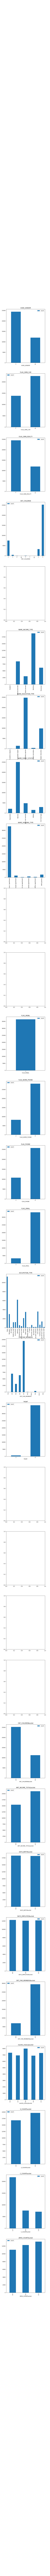

In [27]:

fig, axes= plt.subplots(len(grouped_data_list), 1, figsize=(6, 10*len(grouped_data_list)))
for i, df in enumerate(grouped_data_list):
    # Since there are some continuous variables as well for which we dont need a bar graph, 
    # checking if there are too many rows in the df before
    # proceeding to plot the bar grraph
    if df.shape[0] < 20:
        df.plot(df.columns[0], 'count',kind='bar', 
                ax=axes[i], 
                title=df.columns[0],
                legend=True
               )
    
%matplot plt


In [28]:
plt.close('all')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

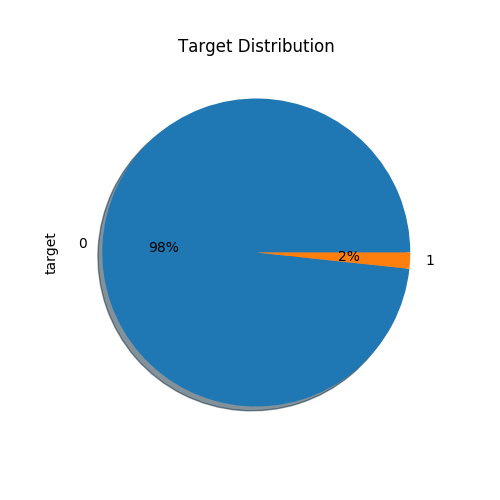

In [29]:
# Plotting the target to see the distribution of 1s and 0s
plt.figure(figsize=(5,5))
merged_df.toPandas().target.value_counts().plot.pie(shadow=True, autopct='%1.0f%%', title='Target Distribution')

%matplot plt

**Observations:** <br>
There are close to 450k applications out of which we have delinquency information for about 36k applications <br>
Among the 36k applications, below are the observations
* Gender: There are about twice the number of female applicants than males
* Car Ownership: About one-third of the applicants own a car
* Home Ownership: Almost two-third of the applicants own a home
* Count of Children:
 * ~75% of the applicants do not have children. 
 * Among those who do, applicants having 1 child are 2x as many as applicants having 2 children.
 * There seems to be few outliers having more than 10 children 
* Income Type: 
 * ~50% of applicants' income is from Working
 * ~25% of applicants' income is from being a Commercial Associate
 * Number of Students is negligible
* Highest Education Level:
 * ~70% of applicants have a secondary education 
 * ~25% of applicants have a higher education
* Family Status: ~70% of applicants are Married
* Housing Type:
 * ~90% of applicants live in a House/apartment
* Mobile Phone: (FLAG_MOBIL) 
 * Every applicant has a mobile phone
 * This column can be **dropped** because it does not add any value to the analysis
* Work Phone: ~75% of applicants have not listed a Work Phone
* Phone: About one-third of applicants have listed a phone
* Email: ~90% of applicants have not listed an email
* Occupation: 
 * About one-third of applicants have not filled their Occupation
 * Laborers are the next highest occupation
* Family Size: 
 * About two-thirds of applicants have family size of 2
 * There seem to be some outliers in this column
* Target:
 * 98% of the applicants are non-delinquent indicating a heavy imbalance of target variable
 


## Analyzing the columns w.r.t target

In [30]:
#Converting the merged DataFrame to Pandas Dataframe for analysis of the columns w.r.t the target variable
pandas_df = merged_df.toPandas()
pandas_df


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

            ID CODE_GENDER  ... C_COUNTbucket ZERO_COUNTbucket
0      5009033           F  ...           1.0              1.0
1      5009304           F  ...           2.0              1.0
2      5009355           F  ...           1.0              2.0
3      5009429           M  ...           1.0              0.0
4      5010070           F  ...           1.0              1.0
...        ...         ...  ...           ...              ...
36452  5149419           F  ...           3.0              1.0
36453  5149601           F  ...           1.0              0.0
36454  5149751           F  ...           2.0              1.0
36455  5150004           M  ...           1.0              2.0
36456  5150044           F  ...           2.0              1.0

[36457 rows x 32 columns]

In [31]:
pandas_df.isna().sum()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

ID                            0
CODE_GENDER                   0
FLAG_OWN_CAR                  0
FLAG_OWN_REALTY               0
CNT_CHILDREN                  0
AMT_INCOME_TOTAL              0
NAME_INCOME_TYPE              0
NAME_EDUCATION_TYPE           0
NAME_FAMILY_STATUS            0
NAME_HOUSING_TYPE             0
DAYS_BIRTH                    0
DAYS_EMPLOYED                 0
FLAG_MOBIL                    0
FLAG_WORK_PHONE               0
FLAG_PHONE                    0
FLAG_EMAIL                    0
OCCUPATION_TYPE           11323
CNT_FAM_MEMBERS               0
target                        0
months_history                0
X_COUNT                       0
C_COUNT                       0
ZERO_COUNT                    0
CNT_CHILDRENbucket            0
AMT_INCOME_TOTALbucket        0
DAYS_BIRTHbucket              0
DAYS_EMPLOYEDbucket           0
CNT_FAM_MEMBERSbucket         0
months_historybucket          0
X_COUNTbucket                 0
C_COUNTbucket                 0
ZERO_COU

Since about one-third of the OCCUPATION_TYPE column is null,

In [32]:
type(pandas_df)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

<class 'pandas.core.frame.DataFrame'>

In [33]:
# Make a list of categorical columns

#app_int_cat_cols= ['CNT_CHILDREN', 'FLAG_WORK_PHONE', 'FLAG_PHONE', 
#                   'FLAG_EMAIL', 'CNT_FAM_MEMBERS']
app_cat_cols = ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 
                'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS',
                'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE'
               ]
# List of columns that have continuous data
app_cont_cols = ['AMT_INCOME_TOTAL', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'X_COUNT', 'C_COUNT', 'ZERO_COUNT']
# Since all the values in FLAG_MOBIL is same, we can drop the column
cols_to_drop=['FLAG_MOBIL']

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

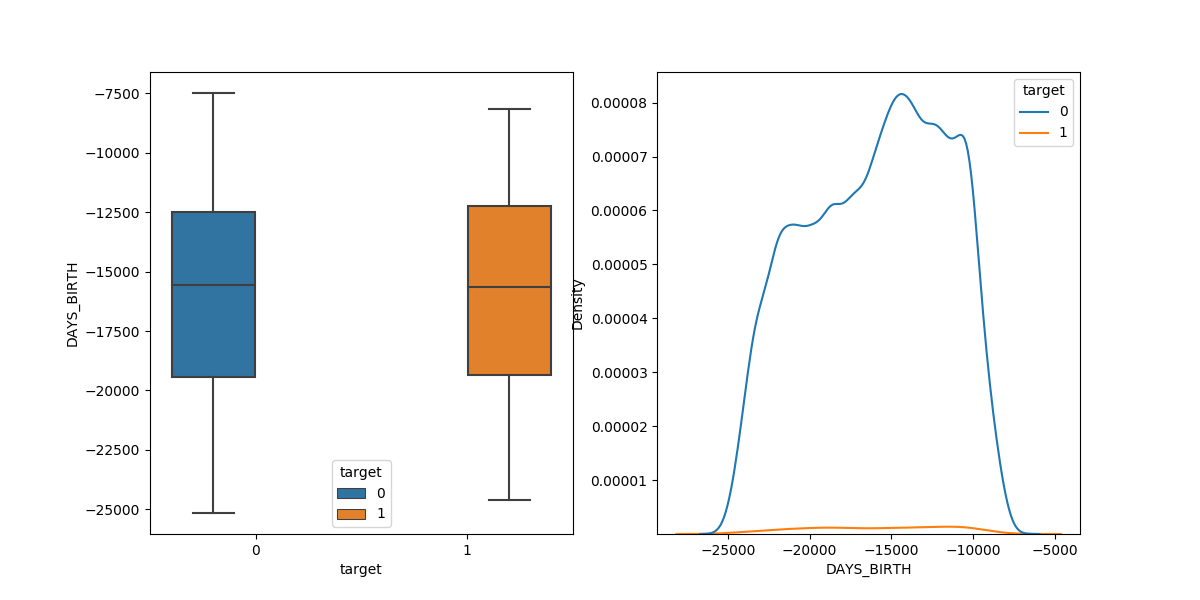

In [34]:
fig, axes = plt.subplots(1,2, figsize=(12,6))

sns.boxplot(data=pandas_df[['target','DAYS_BIRTH']], 
            x='target', y='DAYS_BIRTH', hue='target', ax=axes[0])

sns.kdeplot(data=pandas_df[['target','DAYS_BIRTH']],  
            x='DAYS_BIRTH', hue='target', ax=axes[1])
plt.show()
%matplot plt

**Observation**:
* The median and distribution of data among delinquent and non-delinquents seem to be approximately the same
* Since all thhe values are negative, we can safely consider the absolute value for further analysis

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

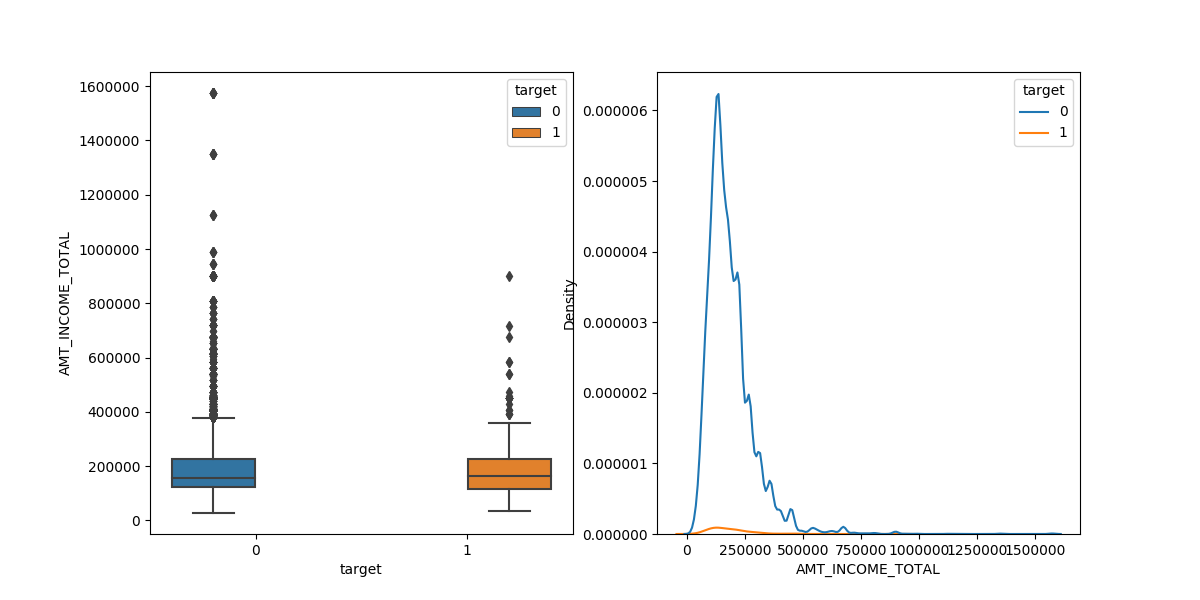

In [35]:
fig, axes = plt.subplots(1,2, figsize=(12,6))

sns.boxplot(data=pandas_df, x='target', y='AMT_INCOME_TOTAL', hue='target', ax=axes[0])

sns.kdeplot(data=pandas_df,  x='AMT_INCOME_TOTAL', hue='target', ax=axes[1])
plt.show()

%matplot plt  

**Observation** 
* We can see that as income increases above 1M, the chance of being delinquent drops drastically
* Most of the data lies below the 500k income 

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

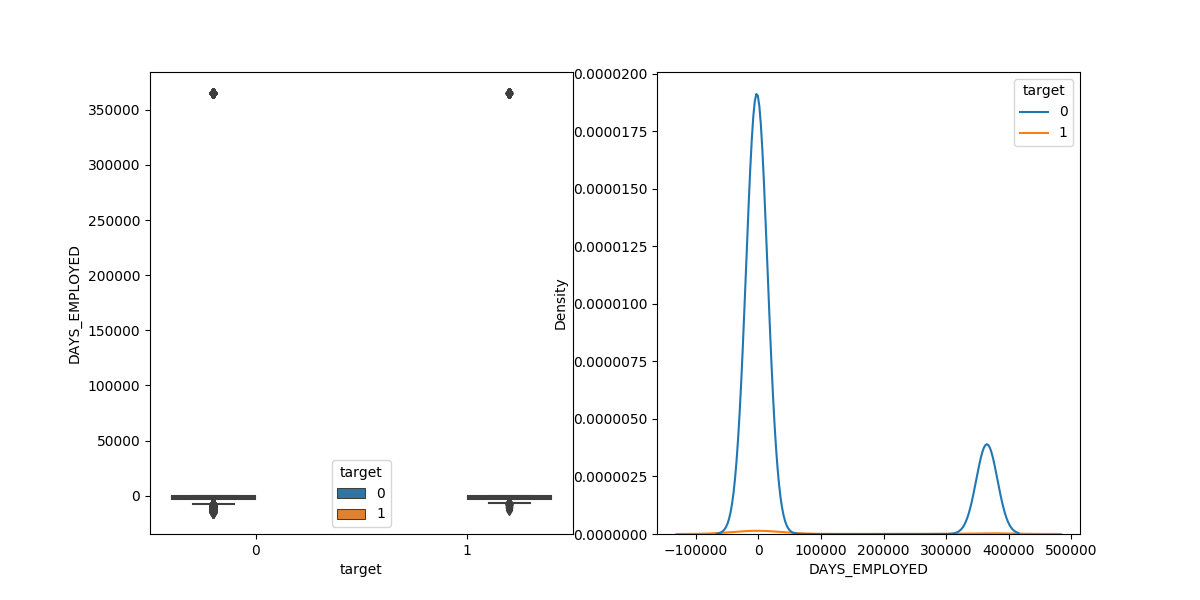

In [36]:
# Plotting DAYS_EMPLOYED w.r.t target
fig, axes = plt.subplots(1,2, figsize=(12,6))

sns.boxplot(data=pandas_df, x='target', y='DAYS_EMPLOYED', hue='target', ax=axes[0])

sns.kdeplot(data=pandas_df,  x='DAYS_EMPLOYED', hue='target', ax=axes[1])
plt.show()

%matplot plt  


**Observations:**
* There are outliers in both delinquent and non-delinquent applicants at around 350,000 days which needs more analysis
* There seem to be both positive and negative values in this column


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

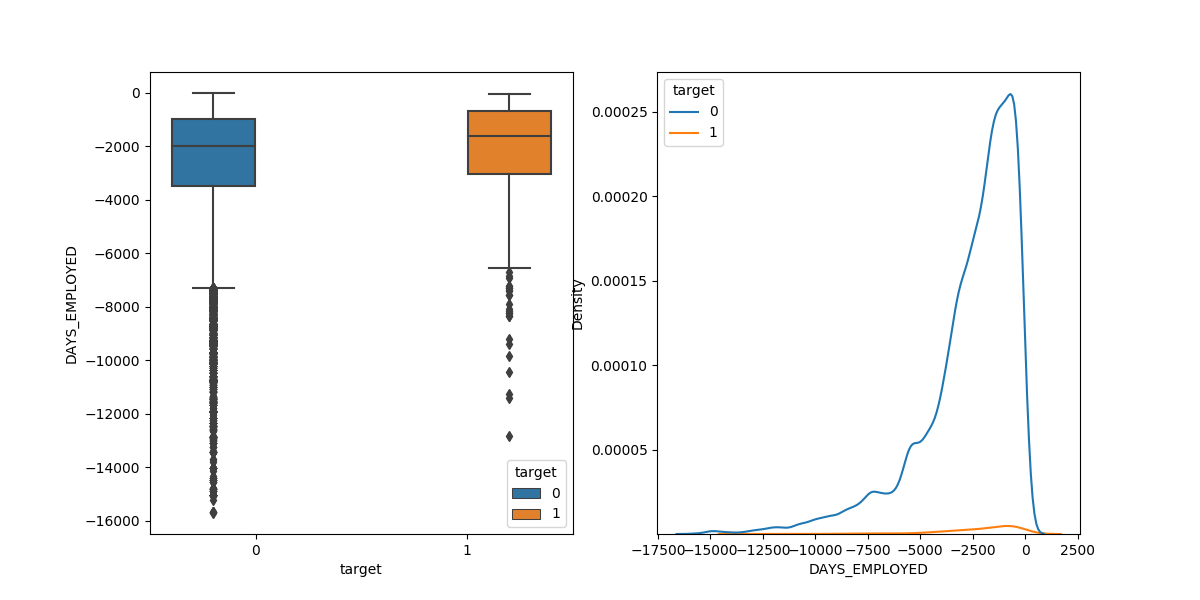

In [37]:
# Plotting DAYS_EMPLOYED without the outliers
fig, axes = plt.subplots(1,2, figsize=(12,6))

sns.boxplot(data=pandas_df[pandas_df.DAYS_EMPLOYED<350_000], 
            x='target', 
            y='DAYS_EMPLOYED',
            hue='target',
            ax=axes[0])

sns.kdeplot(data=pandas_df[pandas_df.DAYS_EMPLOYED<350_000],
            x='DAYS_EMPLOYED',
            hue='target', 
            ax=axes[1])
plt.show()

%matplot plt

**Observations:**
* Data is skewed towards 0
* There are a lot more non-delinquent people beyond 7500 days compared to delinquent


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

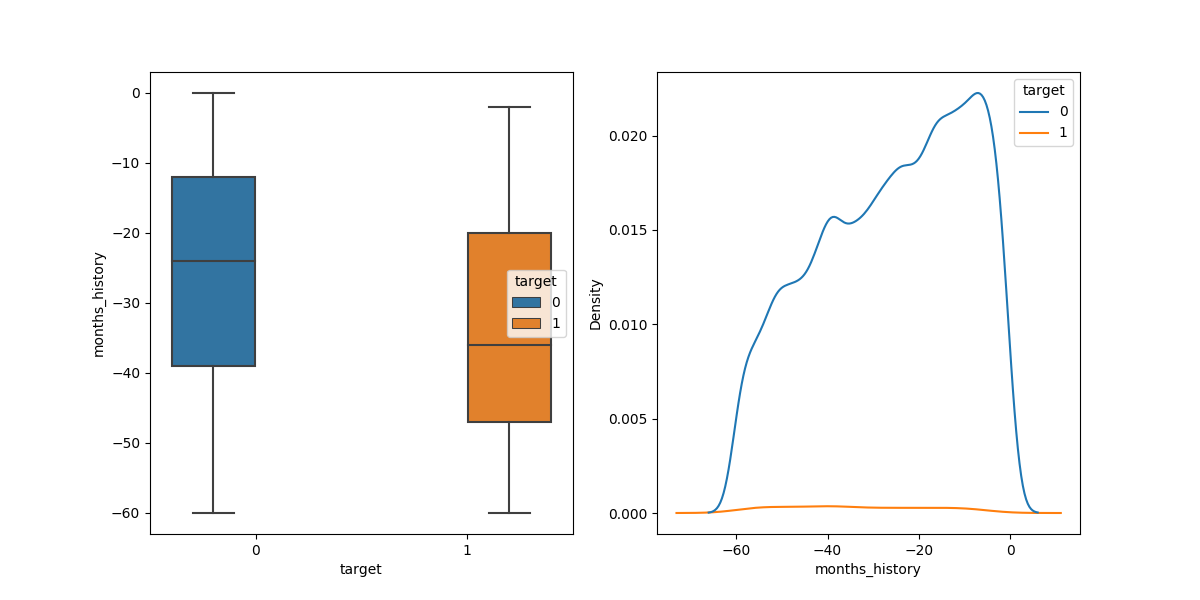

In [38]:
# Plotting Months_History column
fig, axes = plt.subplots(1,2, figsize=(12,6))

sns.boxplot(data=pandas_df, 
            x='target', 
            y='months_history',
            hue='target',
            ax=axes[0])

sns.kdeplot(data=pandas_df,
            x='months_history',
            hue='target', 
            ax=axes[1])
plt.show()

%matplot plt

**Observation**
* The median number of history available for people who default seem to more than for peopl who have not defaulted

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

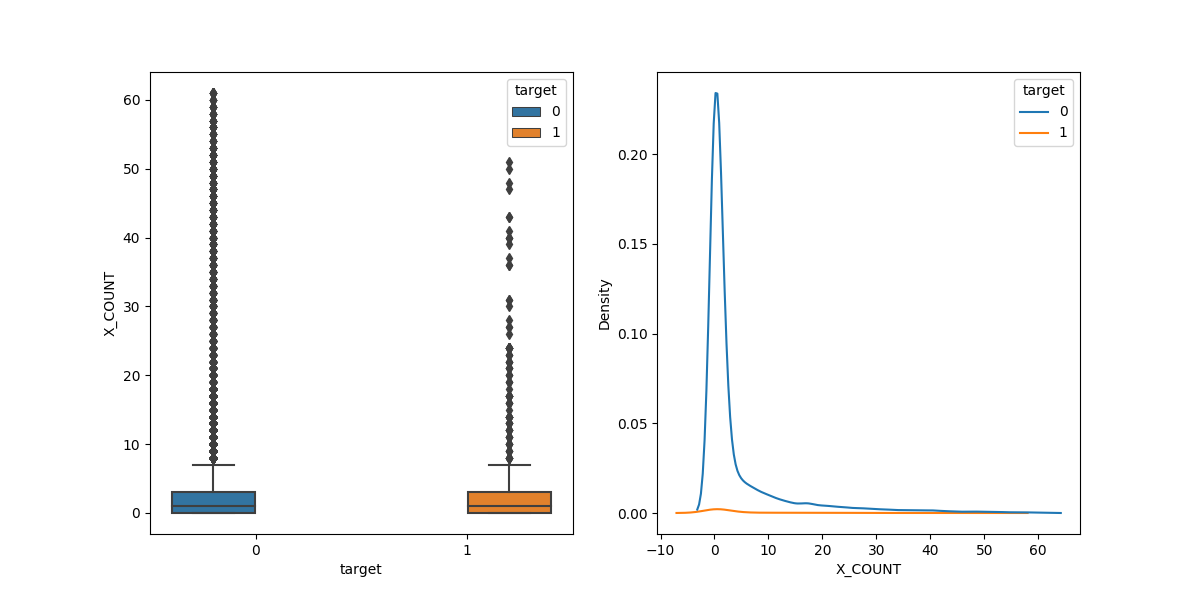

In [39]:
# Plotting Months_History column
fig, axes = plt.subplots(1,2, figsize=(12,6))

sns.boxplot(data=pandas_df, 
            x='target', 
            y='X_COUNT',
            hue='target',
            ax=axes[0])

sns.kdeplot(data=pandas_df,
            x='X_COUNT',
            hue='target', 
            ax=axes[1])
plt.show()

%matplot plt

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

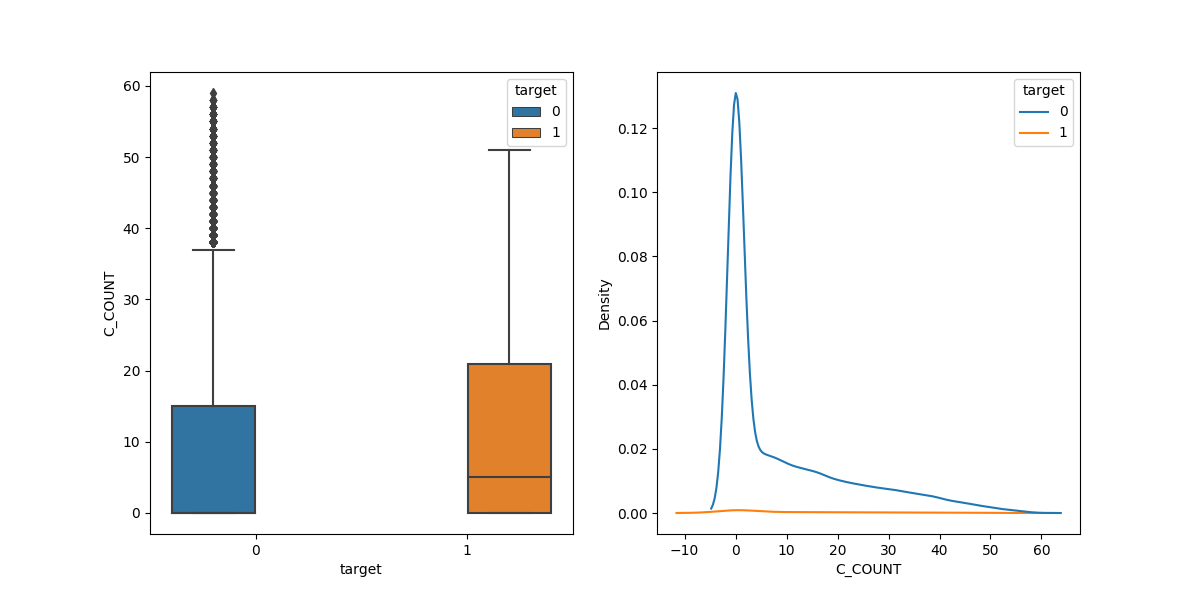

In [40]:
# Plotting Months_History column
fig, axes = plt.subplots(1,2, figsize=(12,6))

sns.boxplot(data=pandas_df, 
            x='target', 
            y='C_COUNT',
            hue='target',
            ax=axes[0])

sns.kdeplot(data=pandas_df,
            x='C_COUNT',
            hue='target', 
            ax=axes[1])
plt.show()

%matplot plt

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

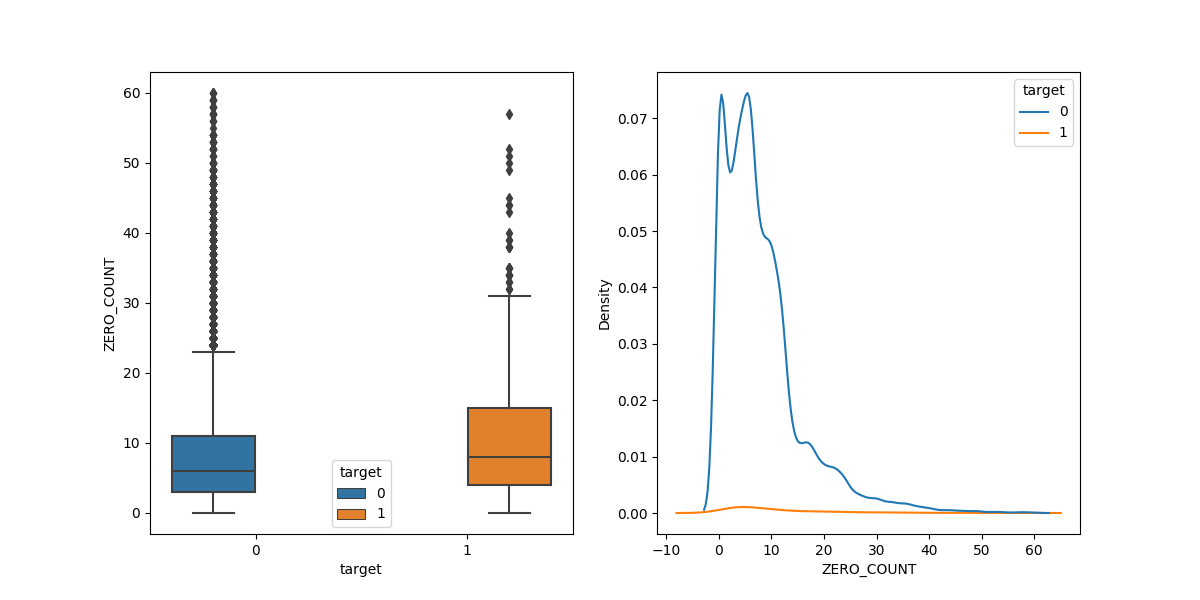

In [41]:
# Plotting Months_History column
fig, axes = plt.subplots(1,2, figsize=(12,6))

sns.boxplot(data=pandas_df, 
            x='target', 
            y='ZERO_COUNT',
            hue='target',
            ax=axes[0])

sns.kdeplot(data=pandas_df,
            x='ZERO_COUNT',
            hue='target', 
            ax=axes[1])
plt.show()

%matplot plt

In [42]:
plt.close('all')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [43]:
# Since there are both positive and negative Values in DAYS_EMPLOYED
pandas_df[pandas_df['DAYS_EMPLOYED'] > 0]['DAYS_EMPLOYED'].value_counts()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

365243    6135
Name: DAYS_EMPLOYED, dtype: int64

In [44]:
merged_df.filter('DAYS_EMPLOYED > 0').select('DAYS_EMPLOYED', 
                                             'NAME_INCOME_TYPE',
                                             'target').groupBy('DAYS_EMPLOYED',
                                                               'NAME_INCOME_TYPE', 
                                                               'target').count().show()
#pandas_df[pandas_df['DAYS_EMPLOYED'] > 0][['DAYS_EMPLOYED', 'NAME_INCOME_TYPE', 'target']].value_counts()


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------+----------------+------+-----+
|DAYS_EMPLOYED|NAME_INCOME_TYPE|target|count|
+-------------+----------------+------+-----+
|       365243|       Pensioner|     0| 6022|
|       365243|       Pensioner|     1|  113|
+-------------+----------------+------+-----+

**Observation:**
* The outlier value in DAYS_EMPLOYED column indicates  and a higher proportion of them are non-delinquent

In [45]:
pandas_df.NAME_INCOME_TYPE.value_counts()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Working                 18819
Commercial associate     8490
Pensioner                6152
State servant            2985
Student                    11
Name: NAME_INCOME_TYPE, dtype: int64

In [46]:
# Since 6135 out of 6152 Pensioners are for applicants with DAYS_EMPLOYED=+365_243 days, 
# lets analyze the other Pensioners
pandas_df[(pandas_df.NAME_INCOME_TYPE == "Pensioner") & (pandas_df.DAYS_EMPLOYED < 365_000)]

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

            ID CODE_GENDER  ... C_COUNTbucket ZERO_COUNTbucket
2458   5116906           M  ...           1.0              1.0
3797   5021303           M  ...           1.0              0.0
4283   5105739           F  ...           2.0              0.0
4364   5021998           M  ...           1.0              2.0
6932   5045929           M  ...           3.0              1.0
9751   5115455           F  ...           3.0              0.0
9785   5149838           F  ...           2.0              0.0
18019  5148694           F  ...           1.0              2.0
19851  5118648           F  ...           3.0              2.0
21058  5092394           M  ...           2.0              2.0
22577  5125816           F  ...           3.0              1.0
24983  5009753           F  ...           2.0              1.0
28928  5116907           M  ...           1.0              1.0
29458  5100118           F  ...           1.0              2.0
30497  5046328           F  ...           1.0          

**Observation:** All the clients whose income type is Pensioner but not their DAYS_EMPLOYED does not indicate Retirement seem to be delinquent

In [47]:
# clossing all figures
plt.close('all')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [48]:
# Since all values in DAYS_BIRTH and DAYS_EMPLOYED are negative, 
# let's consider the absolute value of these columns
pandas_df['DAYS_BIRTH'] = abs(pandas_df.DAYS_BIRTH)
pandas_df['DAYS_EMPLOYED'] = abs(pandas_df.DAYS_EMPLOYED)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

# EDA-Q1: What is the proportion of females in the applicant customer base?

In [49]:
total = merged_df.count()
gender_distribution = merged_df.select('CODE_GENDER').groupBy('CODE_GENDER').count().alias('count')
gender_distribution = gender_distribution.withColumn('normalized_count',
                                                     gender_distribution['count']/total)
gender_distribution.show(truncate=False)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----------+-----+-------------------+
|CODE_GENDER|count|normalized_count   |
+-----------+-----+-------------------+
|F          |24430|0.6701045066791014 |
|M          |12027|0.32989549332089857|
+-----------+-----+-------------------+

**Observation:** Females are 67% of the customer base

In [50]:
for col in app_cat_cols:
    temp_df = pandas_df[[col, 'target']].pivot_table(columns='target', index=col, aggfunc=len)
    temp_df['Percentage of Delinquent']=temp_df[:][1]*100/temp_df.sum(axis=1)
    temp_df.sort_values('Percentage of Delinquent', ascending=False, inplace=True)
    print("---------" + col+"------------")
    print("Normalized Value Counts\n")
    print(pandas_df[col].value_counts(normalize=True))
    print(temp_df)


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

---------CODE_GENDER------------
Normalized Value Counts

F    0.670105
M    0.329895
Name: CODE_GENDER, dtype: float64
target           0    1  Percentage of Delinquent
CODE_GENDER                                      
M            11790  237                  1.970566
F            24051  379                  1.551371
---------FLAG_OWN_CAR------------
Normalized Value Counts

N    0.620292
Y    0.379708
Name: FLAG_OWN_CAR, dtype: float64
target            0    1  Percentage of Delinquent
FLAG_OWN_CAR                                      
N             22222  392                  1.733439
Y             13619  224                  1.618146
---------FLAG_OWN_REALTY------------
Normalized Value Counts

Y    0.672189
N    0.327811
Name: FLAG_OWN_REALTY, dtype: float64
target               0    1  Percentage of Delinquent
FLAG_OWN_REALTY                                      
N                11700  251                  2.100243
Y                24141  365                  1.489431
---------N

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

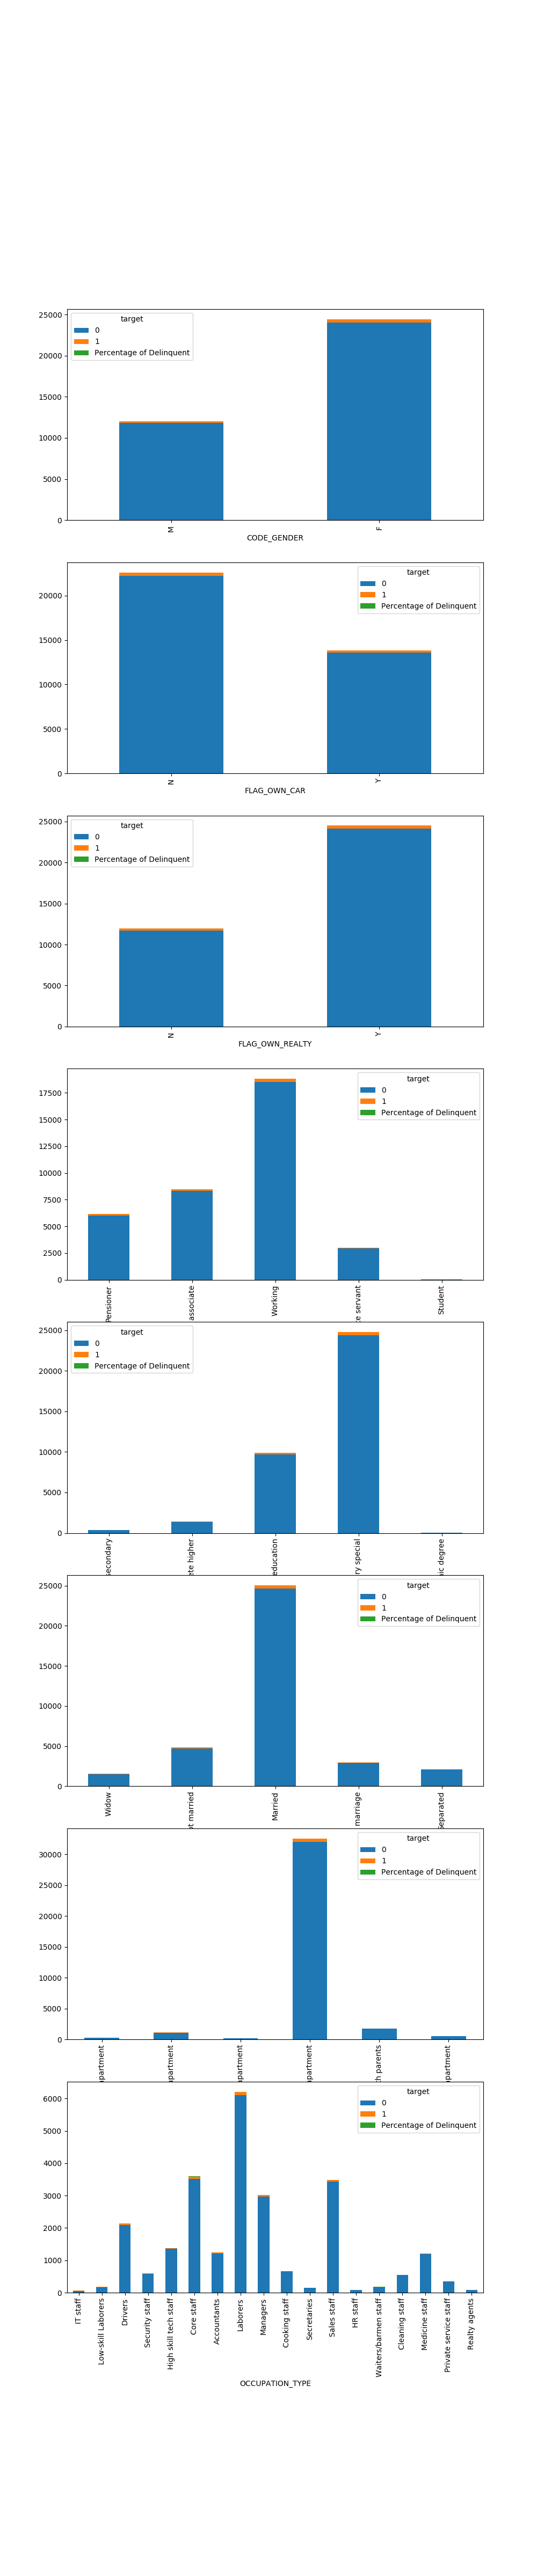

In [51]:
fig, axes= plt.subplots(len(app_cat_cols), 1, figsize=(10, 6*len(app_cat_cols)))
for i, col in enumerate(app_cat_cols):
    temp_df = pandas_df[[col, 'target']].pivot_table(columns='target', index=col, aggfunc=len)
    temp_df['Percentage of Delinquent']=temp_df[:][1]*100/temp_df.sum(axis=1)
    temp_df.sort_values('Percentage of Delinquent', ascending=False, inplace=True)
    temp_df.plot(kind='bar', stacked=True, ax=axes[i])
    plt.show()
%matplot plt

**Observations:**
* CODE_GENDER:
 * 67% of the data are female applicants
 * Male customers have a slightly higher percentage of delinquency compared to Female customers
* FLAG_OWN_CAR: 
 * 62% of the data are of customer who do not own cars
 * Customers who do not own cars have a slight higher percentage of delinquency compared to customers who own cars
* FLAG_OWN_REALTY: 
 * 67% of the data are of customers who own realty
 * Customers who do not own realty have a higher percentage of delinquency compared to customers who do own realty
* NAME_INCOME_TYPE
 * >50% of customers state having income from Working compared to ~23% from Commercial associate
 * Customers with Pension as income have higher percentage of delinquency followed by ones with Commercial Associate and working.
* NAME_EDUCATION_TYPE
 * ~67% of customers have Secondary education as the highest education level
 * Customers with Lower Secondary education have the highest percentage of delinquency followed by Incomplete higher education
* NAME_FAMILY_STATUS
 * 68% of the customers are Married
 * Widows have the highest percentage of delinquents followed by Single customers
* NAME_HOUSING_TYPE
 * ~90% of customers list as residing in a house/apartment
 * Clients residing in Office Apartments have the highest percentage of delinquents followed by Municipal apartments
* OCCUPATION_TYPE
 * ~25% of customers list their occupation type as Laborers 
 * IT staff have the highest percentage of delinquents followed by Low-skill Laborers

In [52]:
bucketed_columns

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

['DAYS_EMPLOYEDbucket', 'AMT_INCOME_TOTALbucket', 'C_COUNTbucket', 'DAYS_BIRTHbucket', 'CNT_CHILDRENbucket', 'X_COUNTbucket', 'ZERO_COUNTbucket', 'CNT_FAM_MEMBERSbucket', 'months_historybucket']

In [53]:
# Printing some statistics of the bucketed columns
for col in bucketed_columns:
    temp_df = pandas_df[[col, 'target']].pivot_table(columns='target', index=col, aggfunc=len)
    temp_df['Percentage of Delinquent']=temp_df[:][1]*100/temp_df.sum(axis=1)
    temp_df.sort_values('Percentage of Delinquent', ascending=False, inplace=True)
    print("---------" + col+"------------")
    print("Normalized Value Counts\n")
    print(pandas_df[col].value_counts(normalize=True))
    print(temp_df)


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

---------DAYS_EMPLOYEDbucket------------
Normalized Value Counts

0.0    0.336040
2.0    0.332995
1.0    0.330965
Name: DAYS_EMPLOYEDbucket, dtype: float64
target                   0    1  Percentage of Delinquent
DAYS_EMPLOYEDbucket                                      
2.0                  11896  244                  2.009885
1.0                  11860  206                  1.707277
0.0                  12085  166                  1.354991
---------AMT_INCOME_TOTALbucket------------
Normalized Value Counts

1.0    0.575555
0.0    0.424445
Name: AMT_INCOME_TOTALbucket, dtype: float64
target                      0    1  Percentage of Delinquent
AMT_INCOME_TOTALbucket                                      
1.0                     20628  355                  1.691846
0.0                     15213  261                  1.686700
---------C_COUNTbucket------------
Normalized Value Counts

1.0    0.597334
3.0    0.208190
2.0    0.194476
Name: C_COUNTbucket, dtype: float64
target             0

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

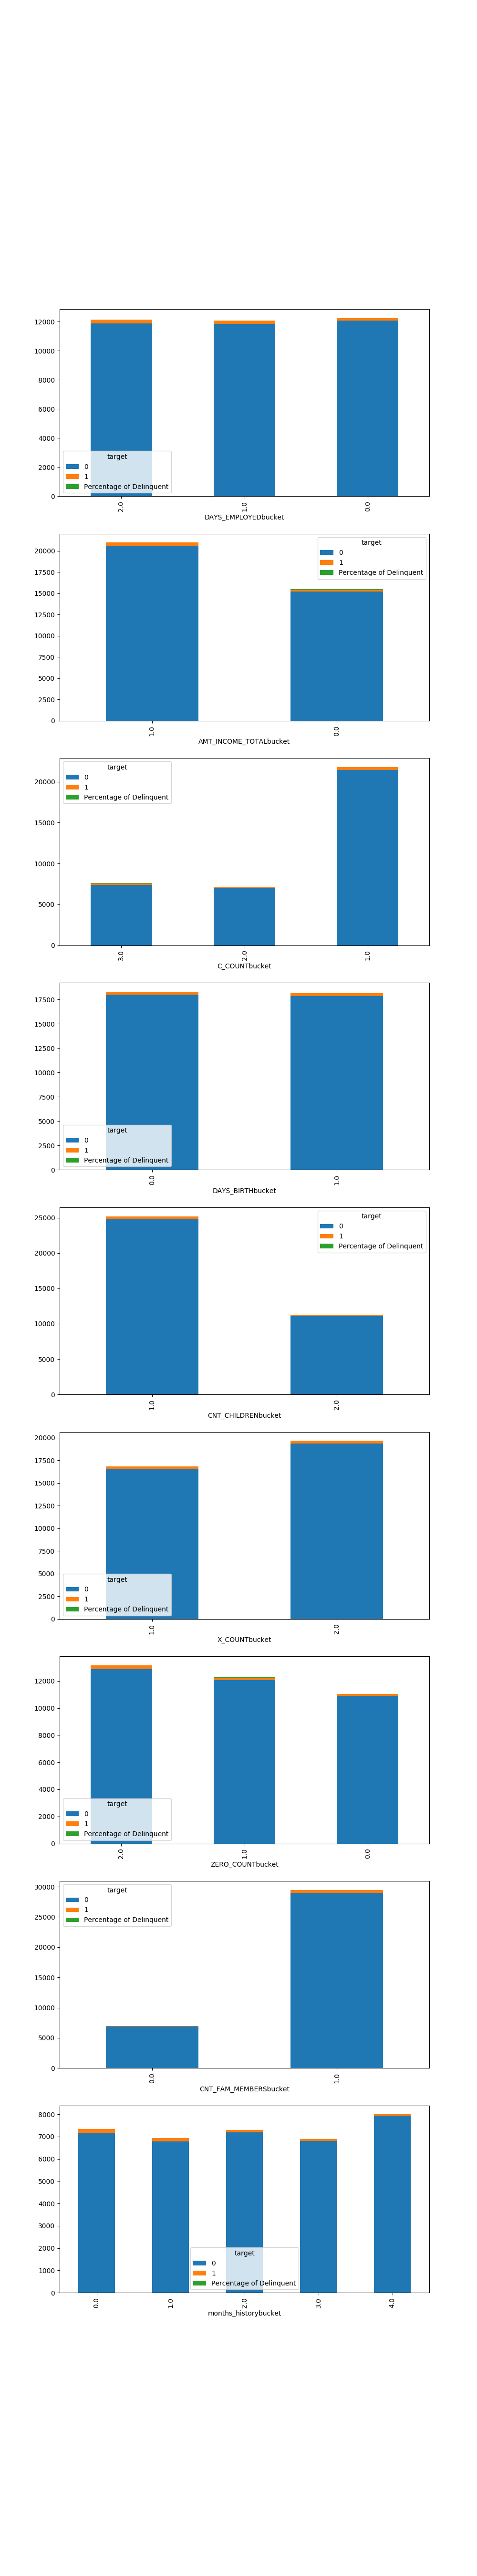

In [54]:

fig, axes= plt.subplots(len(bucketed_columns), 1, figsize=(10, 6*len(bucketed_columns)))
for i, col in enumerate(bucketed_columns):
    temp_df = pandas_df[[col, 'target']].pivot_table(columns='target', index=col, aggfunc=len)
    temp_df['Percentage of Delinquent']=temp_df[:][1]*100/temp_df.sum(axis=1)
    temp_df.sort_values('Percentage of Delinquent', ascending=False, inplace=True)
    temp_df.plot(kind='bar', stacked=True, ax=axes[i])
    plt.show()
%matplot plt

In [55]:
# Closing all matplotlib plots
plt.close('all')


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### Null Check

In [56]:
# Count thhe number of Null values in each of the columns
#merged_df.select([count(when(isnan(c) | isnull(c), c)).alias(c) for c in merged_df.columns]).show()
pandas_df.isna().sum()


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

ID                            0
CODE_GENDER                   0
FLAG_OWN_CAR                  0
FLAG_OWN_REALTY               0
CNT_CHILDREN                  0
AMT_INCOME_TOTAL              0
NAME_INCOME_TYPE              0
NAME_EDUCATION_TYPE           0
NAME_FAMILY_STATUS            0
NAME_HOUSING_TYPE             0
DAYS_BIRTH                    0
DAYS_EMPLOYED                 0
FLAG_MOBIL                    0
FLAG_WORK_PHONE               0
FLAG_PHONE                    0
FLAG_EMAIL                    0
OCCUPATION_TYPE           11323
CNT_FAM_MEMBERS               0
target                        0
months_history                0
X_COUNT                       0
C_COUNT                       0
ZERO_COUNT                    0
CNT_CHILDRENbucket            0
AMT_INCOME_TOTALbucket        0
DAYS_BIRTHbucket              0
DAYS_EMPLOYEDbucket           0
CNT_FAM_MEMBERSbucket         0
months_historybucket          0
X_COUNTbucket                 0
C_COUNTbucket                 0
ZERO_COU

**Observation:** Almost one-third of the data in OCCUPATION_TYPE is null, so we should replace the missing values with a separate constant in order to analyze any significance of the column before we can decide on using the feature for the model

In [57]:
pandas_df['OCCUPATION_TYPE'].fillna(value='Blank', inplace=True)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

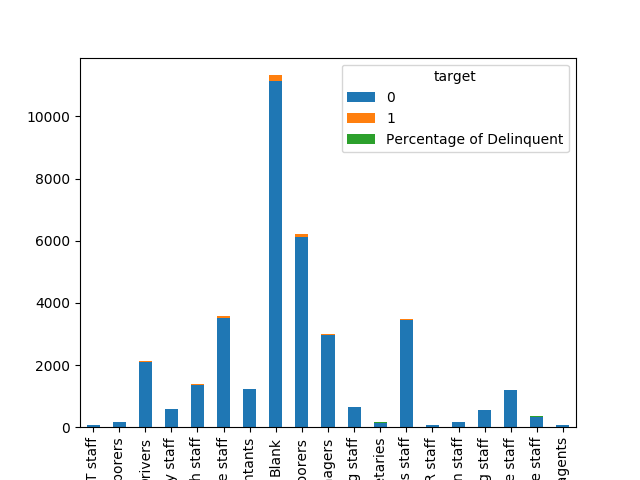

In [58]:
for col in ['OCCUPATION_TYPE']:
    temp_df = pandas_df[[col, 'target']].pivot_table(columns='target', index=col, aggfunc=len)
    temp_df['Percentage of Delinquent']=temp_df[:][1]*100/temp_df.sum(axis=1)
    temp_df.sort_values('Percentage of Delinquent', ascending=False, inplace=True)
    print("---------" + col+"------------")
    print("Normalized Value Counts\n")
    print(pandas_df[col].value_counts(normalize=True))
    print(temp_df)
    temp_df.plot(kind='bar', stacked=True)
    plt.show()
%matplot plt

**Observation:** We see that even with the "Blank" value, the impact it has on the percentage of delinquent is not very high compared to other Occupation Types

In [59]:
#closing all matplotlib figures
plt.close('all')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### Descriptive Statistics

In [60]:
merged_df.select(app_cont_cols).toPandas().describe()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

       AMT_INCOME_TOTAL    DAYS_BIRTH  ...       C_COUNT    ZERO_COUNT
count      3.645700e+04  36457.000000  ...  36457.000000  36457.000000
mean       1.866857e+05 -15975.173382  ...      9.039032      7.972516
std        1.017892e+05   4200.549944  ...     13.026453      7.748513
min        2.700000e+04 -25152.000000  ...      0.000000      0.000000
25%        1.215000e+05 -19438.000000  ...      0.000000      3.000000
50%        1.575000e+05 -15563.000000  ...      0.000000      6.000000
75%        2.250000e+05 -12462.000000  ...     15.000000     11.000000
max        1.575000e+06  -7489.000000  ...     59.000000     60.000000

[8 rows x 6 columns]

In [61]:
merged_df.select('AMT_INCOME_TOTAL').agg({'AMT_INCOME_TOTAL':'mean'}).show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---------------------+
|avg(AMT_INCOME_TOTAL)|
+---------------------+
|   186685.73666236937|
+---------------------+

In [62]:
merged_df.approxQuantile("AMT_INCOME_TOTAL", [0.5], 0.01)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

[166500.0]

## EDA-Q4: What is the average and median salary of the applicant base?

* Salary Income 
 * Median is ~170k while mean is ~187k
* Days Employed:
 * There are negative and positive values in the column. It could be an indication of employment status


In [63]:
# Beforing starting the WOE and IV calculation, let's drop few unwanted columns
print('unwanted columns to be dropped = ', cols_to_drop)
for col in cols_to_drop:
    merged_df = merged_df.drop(col)
print('final list of columns =')
merged_df.columns

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

unwanted columns to be dropped =  ['FLAG_MOBIL']
final list of columns =
['ID', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'FLAG_WORK_PHONE', 'FLAG_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS', 'target', 'months_history', 'X_COUNT', 'C_COUNT', 'ZERO_COUNT', 'CNT_CHILDRENbucket', 'AMT_INCOME_TOTALbucket', 'DAYS_BIRTHbucket', 'DAYS_EMPLOYEDbucket', 'CNT_FAM_MEMBERSbucket', 'months_historybucket', 'X_COUNTbucket', 'C_COUNTbucket', 'ZERO_COUNTbucket']

### Null Values

In [64]:
# Replacing null values in the Occupation_Type with "Blank"
merged_df = merged_df.fillna({'OCCUPATION_TYPE':'Blank'})

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [65]:
merged_df.toPandas().isna().sum()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

ID                        0
CODE_GENDER               0
FLAG_OWN_CAR              0
FLAG_OWN_REALTY           0
CNT_CHILDREN              0
AMT_INCOME_TOTAL          0
NAME_INCOME_TYPE          0
NAME_EDUCATION_TYPE       0
NAME_FAMILY_STATUS        0
NAME_HOUSING_TYPE         0
DAYS_BIRTH                0
DAYS_EMPLOYED             0
FLAG_WORK_PHONE           0
FLAG_PHONE                0
FLAG_EMAIL                0
OCCUPATION_TYPE           0
CNT_FAM_MEMBERS           0
target                    0
months_history            0
X_COUNT                   0
C_COUNT                   0
ZERO_COUNT                0
CNT_CHILDRENbucket        0
AMT_INCOME_TOTALbucket    0
DAYS_BIRTHbucket          0
DAYS_EMPLOYEDbucket       0
CNT_FAM_MEMBERSbucket     0
months_historybucket      0
X_COUNTbucket             0
C_COUNTbucket             0
ZERO_COUNTbucket          0
dtype: int64

# WOE and IV Calculation

In [66]:
# WOE & IV calculation by creating a class

class WOE_IV(object):
    def __init__(self, df: DataFrame, cols_to_woe: [str], label_column: str, good_label: str):
        self.df = df
        self.cols_to_woe = cols_to_woe
        self.label_column = label_column
        self.good_label = good_label
        self.fit_data = {}

    def fit(self):
        for col_to_woe in self.cols_to_woe:
            total_good = self.compute_total_amount_of_good()
            total_bad = self.compute_total_amount_of_bad()
            
            woe_df = self.df.select(col_to_woe)
            categories = woe_df.distinct().collect()
            for category_row in categories:
                category = category_row[col_to_woe]
                good_amount = self.compute_good_amount(col_to_woe, category)
                bad_amount = self.compute_bad_amount(col_to_woe, category)

                good_amount = good_amount if good_amount != 0 else 0.5
                bad_amount = bad_amount if bad_amount != 0 else 0.5

                good_dist = good_amount / total_good
                bad_dist = bad_amount / total_bad

                self.build_fit_data(col_to_woe, category, good_dist, bad_dist)

    def transform(self, df: DataFrame):
        def _encode_woe(col_to_woe_):
            return F.coalesce(
                *[F.when(F.col(col_to_woe_) == category, F.lit(woe_iv['woe']))
                  for category, woe_iv in self.fit_data[col_to_woe_].items()]
            )

        for col_to_woe, woe_info in self.fit_data.items():
            df = df.withColumn(col_to_woe + '_woe', _encode_woe(col_to_woe))
        return df

    def compute_total_amount_of_good(self):
        return self.df.select(self.label_column).filter(F.col(self.label_column) == self.good_label).count()

    def compute_total_amount_of_bad(self):
        return self.df.select(self.label_column).filter(F.col(self.label_column) != self.good_label).count()

    def compute_good_amount(self, col_to_woe: str, category: str):
        return self.df.select(col_to_woe, self.label_column)\
                      .filter(
                            (F.col(col_to_woe) == category) & (F.col(self.label_column) == self.good_label)
                      ).count()

    def compute_bad_amount(self, col_to_woe: str, category: str):
        return self.df.select(col_to_woe, self.label_column)\
                      .filter(
                            (F.col(col_to_woe) == category) & (F.col(self.label_column) != self.good_label)
                      ).count()

    def build_fit_data(self, col_to_woe, category, good_dist, bad_dist):
        woe_info = {
            category: {
                'woe': math.log(good_dist / bad_dist),
                'iv': (good_dist - bad_dist) * math.log(good_dist / bad_dist)
            }
        }

        if col_to_woe not in self.fit_data:
            self.fit_data[col_to_woe] = woe_info
        else:
            self.fit_data[col_to_woe].update(woe_info)

    def compute_iv(self):
        iv_dict = {}

        for woe_col, categories in self.fit_data.items():
            iv_dict[woe_col] = 0
            for category, woe_iv in categories.items():
                iv_dict[woe_col] += woe_iv['iv']
        return iv_dict

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [67]:
merged_df.cache()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

DataFrame[ID: int, CODE_GENDER: string, FLAG_OWN_CAR: string, FLAG_OWN_REALTY: string, CNT_CHILDREN: int, AMT_INCOME_TOTAL: double, NAME_INCOME_TYPE: string, NAME_EDUCATION_TYPE: string, NAME_FAMILY_STATUS: string, NAME_HOUSING_TYPE: string, DAYS_BIRTH: int, DAYS_EMPLOYED: int, FLAG_WORK_PHONE: int, FLAG_PHONE: int, FLAG_EMAIL: int, OCCUPATION_TYPE: string, CNT_FAM_MEMBERS: double, target: int, months_history: int, X_COUNT: bigint, C_COUNT: bigint, ZERO_COUNT: bigint, CNT_CHILDRENbucket: double, AMT_INCOME_TOTALbucket: double, DAYS_BIRTHbucket: double, DAYS_EMPLOYEDbucket: double, CNT_FAM_MEMBERSbucket: double, months_historybucket: double, X_COUNTbucket: double, C_COUNTbucket: double, ZERO_COUNTbucket: double]

In [68]:
# Removing ID and target for the WOE generation
cols_to_woe = list(set(merged_df.columns) - set(['ID','target']) - set(spike_cols))
print(cols_to_woe)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

['FLAG_WORK_PHONE', 'X_COUNTbucket', 'NAME_HOUSING_TYPE', 'DAYS_EMPLOYEDbucket', 'CNT_CHILDRENbucket', 'CNT_FAM_MEMBERSbucket', 'NAME_EDUCATION_TYPE', 'C_COUNTbucket', 'DAYS_BIRTHbucket', 'FLAG_EMAIL', 'FLAG_OWN_REALTY', 'ZERO_COUNTbucket', 'OCCUPATION_TYPE', 'NAME_FAMILY_STATUS', 'FLAG_PHONE', 'CODE_GENDER', 'NAME_INCOME_TYPE', 'AMT_INCOME_TOTALbucket', 'FLAG_OWN_CAR', 'months_historybucket']

In [69]:
# Calculating WOE and IV for all the categorical variables (including bin variables from continous variables)
woe = WOE_IV(merged_df, cols_to_woe, 'target', 1)

# woe encoding
woe.fit()
encoded_df = woe.transform(merged_df)

# information value
ivs = woe.compute_iv()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [70]:
print('WOE=')
print(woe.fit_data)


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

WOE=
{'FLAG_WORK_PHONE': {1: {'woe': 0.07807953701462468, 'iv': 0.0014280406249278209}, 0: {'woe': -0.023889130492183958, 'iv': 0.00043692176133998975}}, 'X_COUNTbucket': {1.0: {'woe': 0.0523228414283264, 'iv': 0.0012946753984795255}, 2.0: {'woe': -0.04696272509259747, 'iv': 0.0011620447812688264}}, 'NAME_HOUSING_TYPE': {'House / apartment': {'woe': -0.018571206026937136, 'iv': 0.0003051632214403507}, 'Municipal apartment': {'woe': 0.4635525645444932, 'iv': 0.008374537278071296}, 'Co-op apartment': {'woe': 0.05626761971934275, 'iv': 1.4993276890360888e-05}, 'Rented apartment': {'woe': -0.19731695709610228, 'iv': 0.0005589709422160452}, 'Office apartment': {'woe': 0.7274358935605129, 'iv': 0.005493184708395624}, 'With parents': {'woe': -0.14567372394426398, 'iv': 0.0009642100724298857}}, 'DAYS_EMPLOYEDbucket': {0.0: {'woe': -0.2241316998292264, 'iv': 0.015174422732080006}, 1.0: {'woe': 0.01055030118967819, 'iv': 3.7027745467417874e-05}, 2.0: {'woe': 0.1768115421050245, 'iv': 0.011350154

In [71]:
print('IV = ')
ivs

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

IV = 
{'FLAG_WORK_PHONE': 0.0018649623862678107, 'X_COUNTbucket': 0.002456720179748352, 'NAME_HOUSING_TYPE': 0.015711059499443562, 'DAYS_EMPLOYEDbucket': 0.02656160470562366, 'CNT_CHILDRENbucket': 0.00034653405448102837, 'CNT_FAM_MEMBERSbucket': 0.007264393022441308, 'NAME_EDUCATION_TYPE': 0.009216510365458699, 'C_COUNTbucket': 0.03776429479738786, 'DAYS_BIRTHbucket': 3.436496717114655e-05, 'FLAG_EMAIL': 0.00036647741069788757, 'FLAG_OWN_REALTY': 0.028349157710111456, 'ZERO_COUNTbucket': 0.0467813041862974, 'OCCUPATION_TYPE': 0.0619733801957539, 'NAME_FAMILY_STATUS': 0.030119259773091368, 'FLAG_PHONE': 0.0001503891689122608, 'CODE_GENDER': 0.01358137166735823, 'NAME_INCOME_TYPE': 0.018047025803906012, 'AMT_INCOME_TOTALbucket': 2.344582487318753e-06, 'FLAG_OWN_CAR': 0.0011443033795676995, 'months_historybucket': 0.20510478684007277}

In [72]:
# Storing the IVs in a pandas Dataframe. 
# Rounding the IVs to 3 decimals because the lowest threshold is 0.002

ivs_df = pd.DataFrame(data=[round(val, 3) for val in ivs.values()], 
                      index=ivs.keys(),
                      columns=['IV'])
ivs_df.sort_values('IV', ascending=False)


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

                           IV
months_historybucket    0.205
OCCUPATION_TYPE         0.062
ZERO_COUNTbucket        0.047
C_COUNTbucket           0.038
NAME_FAMILY_STATUS      0.030
FLAG_OWN_REALTY         0.028
DAYS_EMPLOYEDbucket     0.027
NAME_INCOME_TYPE        0.018
NAME_HOUSING_TYPE       0.016
CODE_GENDER             0.014
NAME_EDUCATION_TYPE     0.009
CNT_FAM_MEMBERSbucket   0.007
X_COUNTbucket           0.002
FLAG_WORK_PHONE         0.002
FLAG_OWN_CAR            0.001
DAYS_BIRTHbucket        0.000
FLAG_EMAIL              0.000
CNT_CHILDRENbucket      0.000
FLAG_PHONE              0.000
AMT_INCOME_TOTALbucket  0.000

**Observation:**
* Considering the Not-useful variables as IV<0.002:
 * FLAG_WORK_PHONE    
 * FLAG_OWN_CAR          
 * DAYS_BIRTHbucket      
 * FLAG_EMAIL            
 * FLAG_PHONE            
 * CNT_CHILDRENbucket    
 * AMT_INCOME_TOTALbucket
* Weak Variables as 0.002 < IV:
 * months_historybucket   
 * OCCUPATION_TYPE        
 * NAME_FAMILY_STATUS     
 * FLAG_OWN_REALTY        
 * DAYS_EMPLOYEDbucket    
 * NAME_INCOME_TYPE       
 * NAME_HOUSING_TYPE      
 * CODE_GENDER            
 * NAME_EDUCATION_TYPE    
 * CNT_FAM_MEMBERSbucket  
* As can be seen all the available features are either not useful or weak based on their IV 


In [73]:
# Checking if there are any null values in the encoded_df
encoded_df.toPandas().isna().sum()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

ID                            0
CODE_GENDER                   0
FLAG_OWN_CAR                  0
FLAG_OWN_REALTY               0
CNT_CHILDREN                  0
AMT_INCOME_TOTAL              0
NAME_INCOME_TYPE              0
NAME_EDUCATION_TYPE           0
NAME_FAMILY_STATUS            0
NAME_HOUSING_TYPE             0
DAYS_BIRTH                    0
DAYS_EMPLOYED                 0
FLAG_WORK_PHONE               0
FLAG_PHONE                    0
FLAG_EMAIL                    0
OCCUPATION_TYPE               0
CNT_FAM_MEMBERS               0
target                        0
months_history                0
X_COUNT                       0
C_COUNT                       0
ZERO_COUNT                    0
CNT_CHILDRENbucket            0
AMT_INCOME_TOTALbucket        0
DAYS_BIRTHbucket              0
DAYS_EMPLOYEDbucket           0
CNT_FAM_MEMBERSbucket         0
months_historybucket          0
X_COUNTbucket                 0
C_COUNTbucket                 0
ZERO_COUNTbucket              0
FLAG_WOR

In [74]:
encoded_df.columns

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

['ID', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'FLAG_WORK_PHONE', 'FLAG_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS', 'target', 'months_history', 'X_COUNT', 'C_COUNT', 'ZERO_COUNT', 'CNT_CHILDRENbucket', 'AMT_INCOME_TOTALbucket', 'DAYS_BIRTHbucket', 'DAYS_EMPLOYEDbucket', 'CNT_FAM_MEMBERSbucket', 'months_historybucket', 'X_COUNTbucket', 'C_COUNTbucket', 'ZERO_COUNTbucket', 'FLAG_WORK_PHONE_woe', 'X_COUNTbucket_woe', 'NAME_HOUSING_TYPE_woe', 'DAYS_EMPLOYEDbucket_woe', 'CNT_CHILDRENbucket_woe', 'CNT_FAM_MEMBERSbucket_woe', 'NAME_EDUCATION_TYPE_woe', 'C_COUNTbucket_woe', 'DAYS_BIRTHbucket_woe', 'FLAG_EMAIL_woe', 'FLAG_OWN_REALTY_woe', 'ZERO_COUNTbucket_woe', 'OCCUPATION_TYPE_woe', 'NAME_FAMILY_STATUS_woe', 'FLAG_PHONE_woe', 'CODE_GENDER_woe', 'NAME_INCOME_TYPE_woe', 'AMT_INCOME_TOTALbucket_woe', 'FLAG_OWN_CAR_woe',

In [75]:
# Saving the dataframe to S3 bucket as a checkpoint
if use_s3_to_save_checkpoints:
    encoded_df.write.csv(s3_bucket_path + 'checkpoint3.csv', header=True)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [76]:
# Loading the encoded_df
if use_s3_to_load_checkpoints:
    encoded_df = spark.read.csv(s3_bucket_path + 'checkpoint3.csv', 
                                header=True,
                                inferSchema=True)

encoded_df.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- ID: integer (nullable = true)
 |-- CODE_GENDER: string (nullable = true)
 |-- FLAG_OWN_CAR: string (nullable = true)
 |-- FLAG_OWN_REALTY: string (nullable = true)
 |-- CNT_CHILDREN: integer (nullable = true)
 |-- AMT_INCOME_TOTAL: double (nullable = true)
 |-- NAME_INCOME_TYPE: string (nullable = true)
 |-- NAME_EDUCATION_TYPE: string (nullable = true)
 |-- NAME_FAMILY_STATUS: string (nullable = true)
 |-- NAME_HOUSING_TYPE: string (nullable = true)
 |-- DAYS_BIRTH: integer (nullable = true)
 |-- DAYS_EMPLOYED: integer (nullable = true)
 |-- FLAG_WORK_PHONE: integer (nullable = true)
 |-- FLAG_PHONE: integer (nullable = true)
 |-- FLAG_EMAIL: integer (nullable = true)
 |-- OCCUPATION_TYPE: string (nullable = false)
 |-- CNT_FAM_MEMBERS: double (nullable = true)
 |-- target: integer (nullable = true)
 |-- months_history: integer (nullable = true)
 |-- X_COUNT: long (nullable = true)
 |-- C_COUNT: long (nullable = true)
 |-- ZERO_COUNT: long (nullable = true)
 |-- CNT_CHILDREN

In [77]:
encoded_df.cache()
encoded_df.columns

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

['ID', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'FLAG_WORK_PHONE', 'FLAG_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS', 'target', 'months_history', 'X_COUNT', 'C_COUNT', 'ZERO_COUNT', 'CNT_CHILDRENbucket', 'AMT_INCOME_TOTALbucket', 'DAYS_BIRTHbucket', 'DAYS_EMPLOYEDbucket', 'CNT_FAM_MEMBERSbucket', 'months_historybucket', 'X_COUNTbucket', 'C_COUNTbucket', 'ZERO_COUNTbucket', 'FLAG_WORK_PHONE_woe', 'X_COUNTbucket_woe', 'NAME_HOUSING_TYPE_woe', 'DAYS_EMPLOYEDbucket_woe', 'CNT_CHILDRENbucket_woe', 'CNT_FAM_MEMBERSbucket_woe', 'NAME_EDUCATION_TYPE_woe', 'C_COUNTbucket_woe', 'DAYS_BIRTHbucket_woe', 'FLAG_EMAIL_woe', 'FLAG_OWN_REALTY_woe', 'ZERO_COUNTbucket_woe', 'OCCUPATION_TYPE_woe', 'NAME_FAMILY_STATUS_woe', 'FLAG_PHONE_woe', 'CODE_GENDER_woe', 'NAME_INCOME_TYPE_woe', 'AMT_INCOME_TOTALbucket_woe', 'FLAG_OWN_CAR_woe',

Exception in thread cell_monitor-68:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/opt/conda/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 178, in cell_monitor
    job_binned_stages[job_id][stage_id] = all_stages[stage_id]
KeyError: 1595



## Bivariate Analysis


 Converting the Categorical String columns into integers so that we can perform correlation on them

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

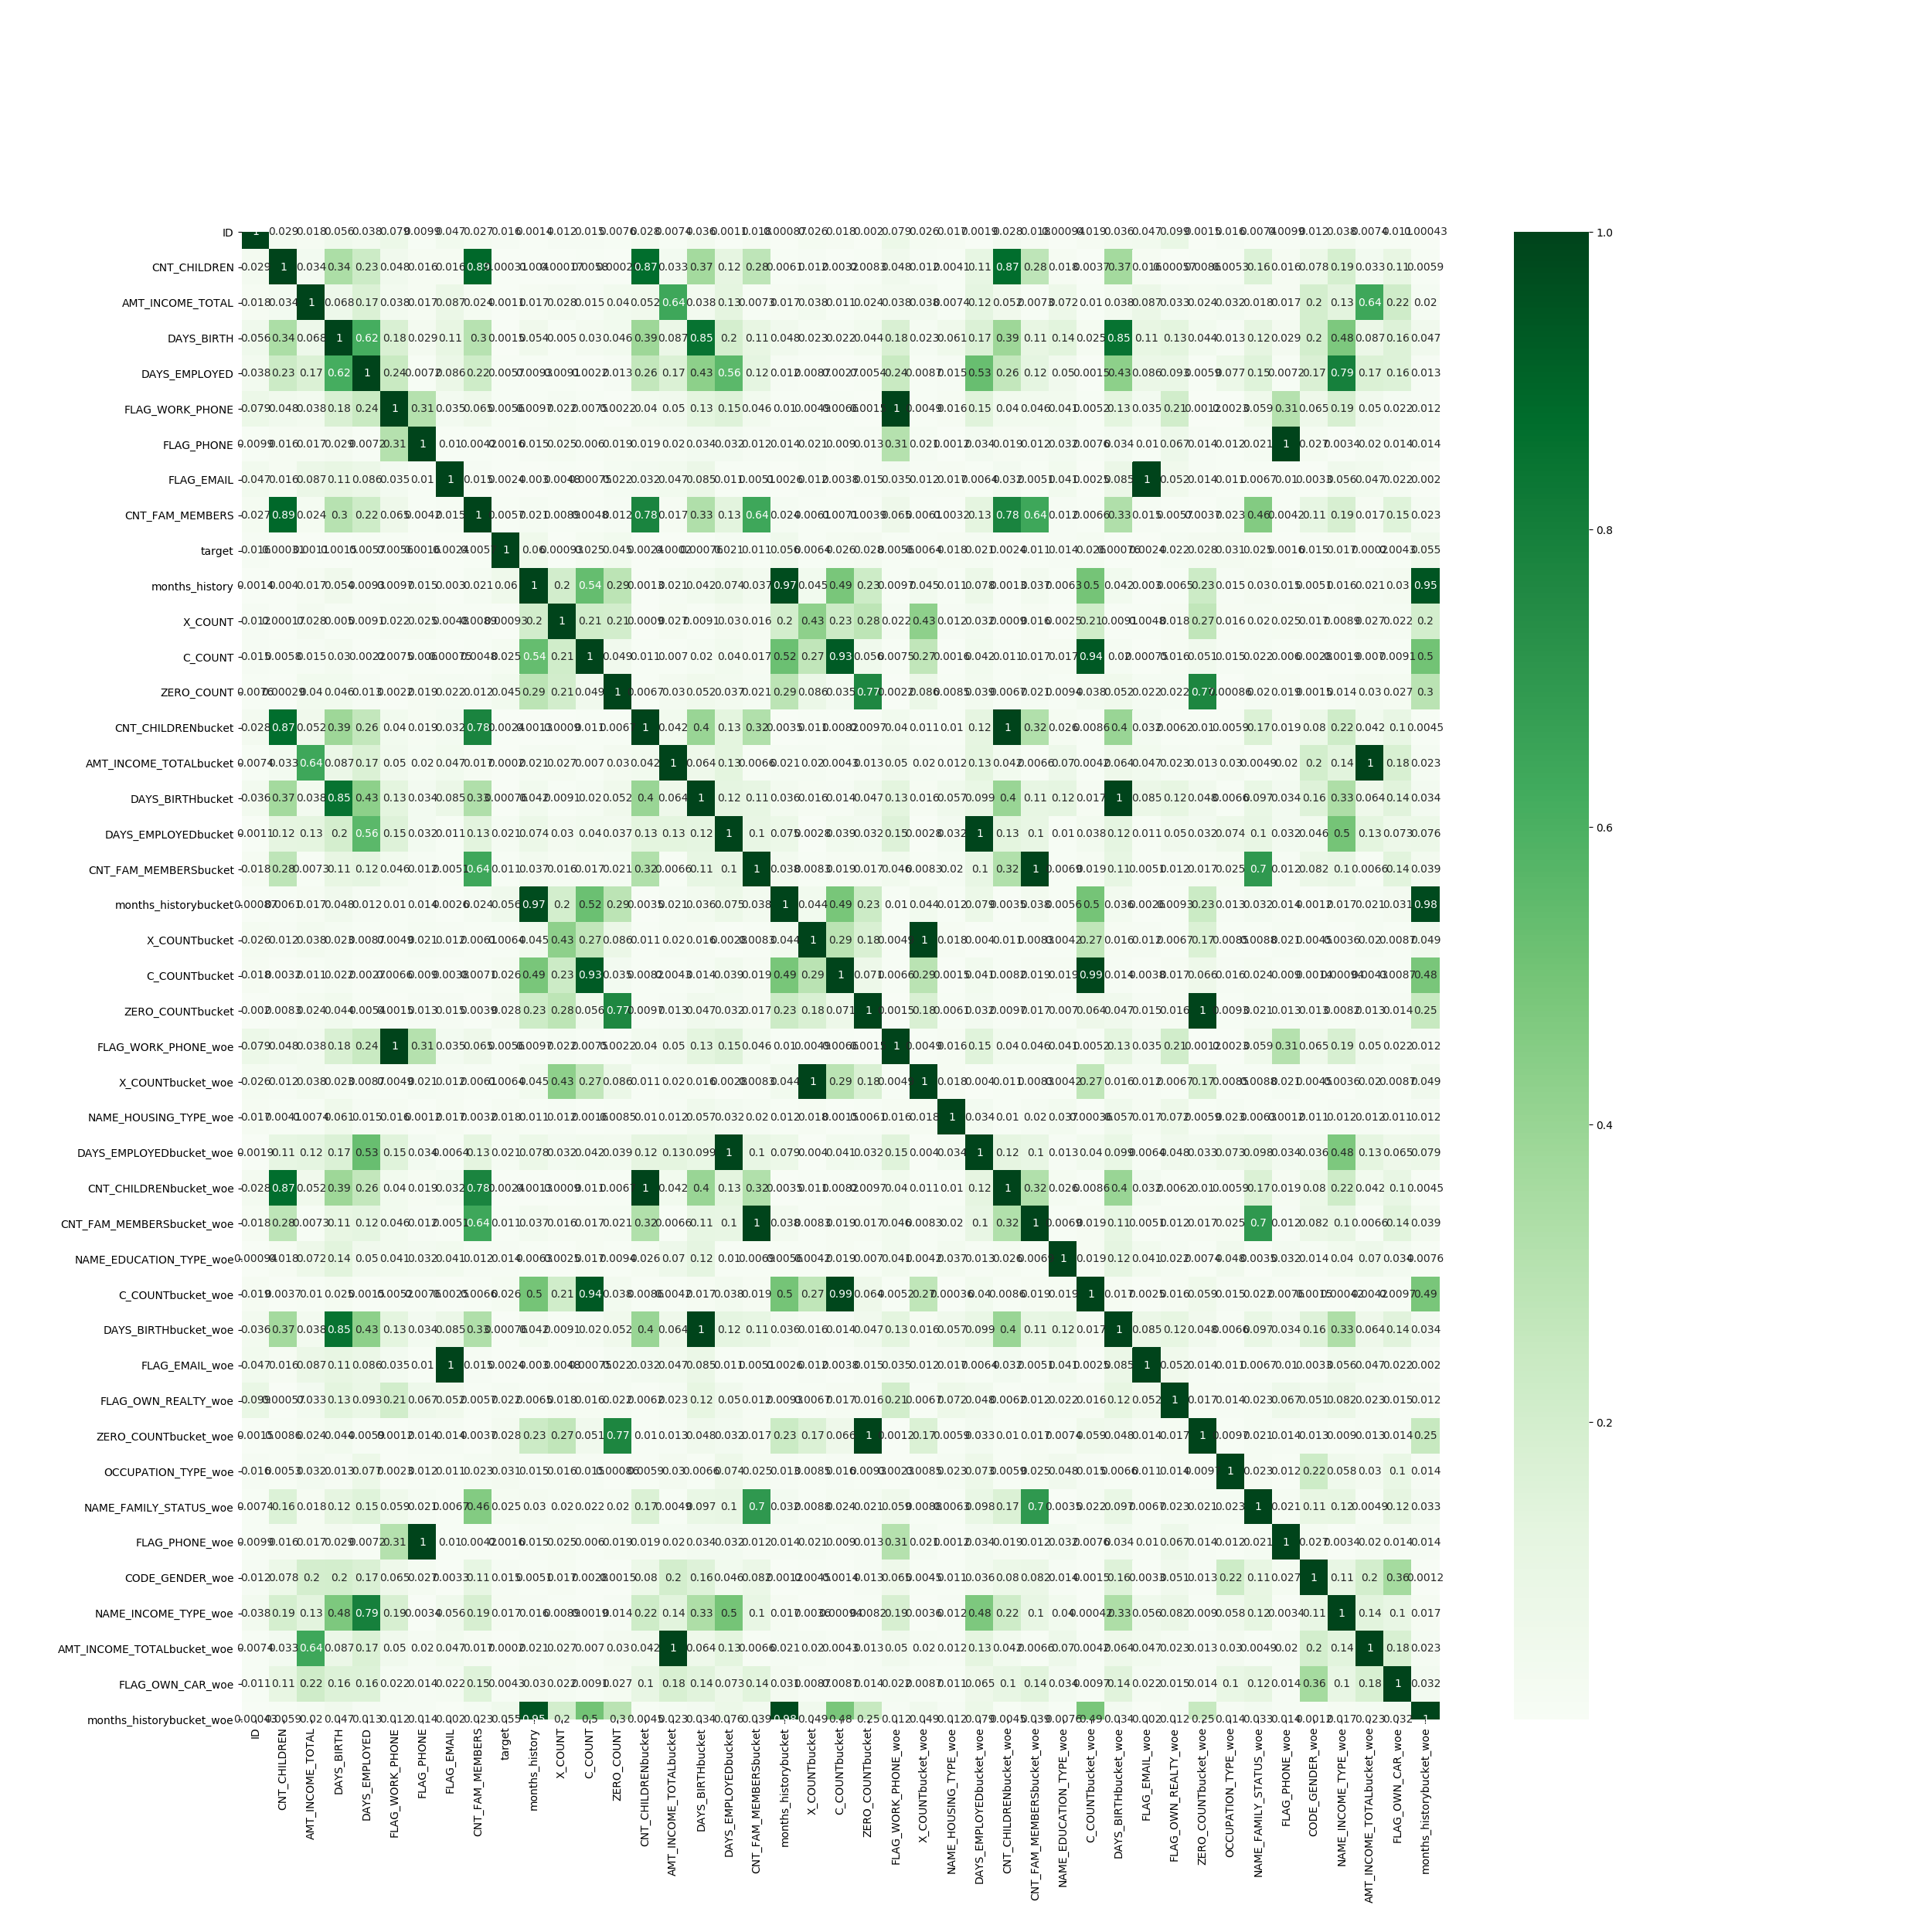

In [78]:
corr= encoded_df.toPandas().corr()
plt.figure(figsize=(25,25))
sns.heatmap(abs(corr), annot=True, cmap='Greens')
%matplot plt

* Considering a threshold of correlatiion value as 0.7 

In [79]:
high_corr = []
for i in range(corr.shape[0]):
    for j in range(corr.shape[1]):
        if i < j:
            if (corr.iloc[i, j] > 0.6) and \
                (corr.index[i] != corr.columns[j]) :
                high_corr.append(corr.index[i] + " <-> " +
                                 corr.index[j] + " ->" +
                                 str(corr.iloc[i,j])
                                )


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [80]:
print(*high_corr, sep='\n')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

CNT_CHILDREN <-> CNT_FAM_MEMBERS ->0.8891141560152886
CNT_CHILDREN <-> CNT_CHILDRENbucket ->0.8673429516180237
AMT_INCOME_TOTAL <-> AMT_INCOME_TOTALbucket ->0.6402569252152231
AMT_INCOME_TOTAL <-> AMT_INCOME_TOTALbucket_woe ->0.6402569252151125
DAYS_BIRTH <-> DAYS_BIRTHbucket ->0.8514673528434429
DAYS_EMPLOYED <-> NAME_INCOME_TYPE_woe ->0.7948150111627664
FLAG_WORK_PHONE <-> FLAG_WORK_PHONE_woe ->1.0000000000009202
FLAG_PHONE <-> FLAG_PHONE_woe ->0.9999999999998378
CNT_FAM_MEMBERS <-> CNT_CHILDRENbucket ->0.7802328383699059
CNT_FAM_MEMBERS <-> CNT_FAM_MEMBERSbucket ->0.6400838985474652
months_history <-> months_historybucket ->0.9730735872617756
C_COUNT <-> C_COUNTbucket ->0.9268192367263988
C_COUNT <-> C_COUNTbucket_woe ->0.9360279141953656
ZERO_COUNT <-> ZERO_COUNTbucket ->0.7671837108013668
ZERO_COUNT <-> ZERO_COUNTbucket_woe ->0.7731824551021462
AMT_INCOME_TOTALbucket <-> AMT_INCOME_TOTALbucket_woe ->0.9999999999996427
DAYS_EMPLOYEDbucket <-> DAYS_EMPLOYEDbucket_woe ->0.99521790467

## EDA-Q3: Is there any correlation between the customer's income level and education level?

In [81]:
corr['AMT_INCOME_TOTAL']['NAME_EDUCATION_TYPE_woe']

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

0.07233571250801524

In [82]:
# Correlation.corr(encoded_df.select('AMT_INCOME_TOTAL', 'NAME_EDUCATION_TYPE_woe'),
#                                "AMT_INCOME_TOTAL",
#                                "pearson").collect()[0][0]


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [83]:
encoded_df_count = encoded_df.count()
temp_df = encoded_df.select(['CODE_GENDER', 
               'FLAG_OWN_CAR',
               lit(1).alias('count')]).toPandas().pivot_table(values='count',
                                                              index='CODE_GENDER', 
                                                              columns='FLAG_OWN_CAR', 
                                                              aggfunc="count"
                                                             )
temp_df*100/temp_df.sum(axis=0)


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FLAG_OWN_CAR          N         Y
CODE_GENDER                      
F             80.304236  45.29365
M             19.695764  54.70635

## EDA-Q2: Is homeownership higher among male applicants or female applicants?


In [84]:
temp_df = encoded_df.select(['CODE_GENDER', 
               'FLAG_OWN_REALTY',
               lit(1).alias('count')]).toPandas().pivot_table(values='count',
                                                              index='CODE_GENDER', 
                                                              columns='FLAG_OWN_REALTY', 
                                                              aggfunc="count"
                                                             )
temp_df*100/temp_df.sum(axis=0)


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FLAG_OWN_REALTY          N          Y
CODE_GENDER                          
F                63.593005  68.677059
M                36.406995  31.322941

**Observations:**
* Percentage of Female applicants who own a home is twice that of male applicants
* 

## EDA-Q5: Is the proportion of bad customers higher for people who own cars?

In [85]:
col1, col2 = 'target', 'FLAG_OWN_CAR'
temp_df = encoded_df.select([col1, 
               col2,
               lit(1).alias('count')]).toPandas().pivot_table(values='count',
                                                              index=col1, 
                                                              columns=col2, 
                                                              aggfunc="count"
                                                             )

temp_df*100/temp_df.sum(axis=0)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FLAG_OWN_CAR          N          Y
target                            
0             98.266561  98.381854
1              1.733439   1.618146

**Observation:** Among the people who own cars, the proportion of bad customers is extremely low compared to good customers

## EDA-Q6: Is the proportion of bad customers higher for those living on rent than the rest of the population?


In [86]:
col1, col2 = 'target' , 'FLAG_OWN_REALTY'
temp_df = encoded_df.select([col1, 
               col2,
               lit(1).alias('count')]).toPandas().pivot_table(values='count',
                                                              index=col1, 
                                                              columns=col2, 
                                                              aggfunc="count"
                                                             )
temp_df*100/temp_df.sum(axis=0)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FLAG_OWN_REALTY          N          Y
target                               
0                97.899757  98.510569
1                 2.100243   1.489431

Assuming that people living on rent refers to people who do not own a house <br>
**Observation:** Among the people who rent, bad customers are a very small proportion

## EDA-Q7: Is the proportion of bad customers higher for those who are single than married customers?


In [87]:
col1, col2 =  'NAME_FAMILY_STATUS', 'target'
temp_df = encoded_df.select([col1, 
               col2,
               lit(1).alias('count')]).toPandas().pivot_table(values='count',
                                                              index=col1, 
                                                              columns=col2, 
                                                              aggfunc="count"
                                                             )
temp_df*100/temp_df.sum(axis=0)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

target                        0          1
NAME_FAMILY_STATUS                        
Civil marriage         8.088502   7.467532
Married               68.789933  63.798701
Separated              5.781089   5.032468
Single / not married  13.191596  16.396104
Widow                  4.148880   7.305195

**Observation:** Among the bad customers, singles are less than 20% that of the married ones

# Model Building

In [88]:
def stratifiedTrainTestSample(df, train_frac, labelCol='target', idCol = 'ID'):
    '''
    Function to generate train-test split of dataframe df based on the training fraction 
        provided in train_frac. The train and test dataset are mutually exclusive with 
        no overlap. This is achieved using the idCol.
    df: PySpark SQL DataFrame
    train_frac: Float in the range of 0 to 1, The fraction of training data to be fetched
        from df, the rest of the data will go to Testing data
    labelCol: String, default='target'. The name of the column that contains the positive 
        and negative labels in df
    idCol: String, default='ID'. The name of the column that serves as a unique identifier
        of each rows in df. This is used to extract test dataset.
    '''
    ctx = df.groupby(labelCol).count()
    # find the fraction of each value in the labelCol
    print(f'initial ctx = {ctx}')
    ctx = ctx.withColumn('frac', ctx['count']/ df.count())
    print(f'ctx = {ctx}')
    frac = ctx.select(labelCol, "frac").rdd.collectAsMap()
    # Find the number of positive and negative class items should be fetched
    # based on the above frac and train_frac
    print("Target Fractions = ", frac)
    pos = int(floor(frac[1] * train_frac * df.count()))
    neg = int(floor(frac[0] * train_frac * df.count()))
    print(f'positive count = {pos}, negative count ={neg}')
    posDF = df.filter(df[labelCol] == 1).orderBy(rand(seed=2018)).limit(pos)
    negDF = df.filter(df[labelCol] == 0).orderBy(rand(seed=2018)).limit(neg)
    train_df = posDF.unionAll(negDF).orderBy(rand(seed=2018))
    test_df = df.join(train_df, idCol, 'left_anti')
    return train_df, test_df



VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Logistic Regression Model 

In [89]:
feature_cols = [f + "_woe" for f in ivs_df[ivs_df['IV'] >= 0.002].index.values]
feature_cols

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

['FLAG_WORK_PHONE_woe', 'X_COUNTbucket_woe', 'NAME_HOUSING_TYPE_woe', 'DAYS_EMPLOYEDbucket_woe', 'CNT_FAM_MEMBERSbucket_woe', 'NAME_EDUCATION_TYPE_woe', 'C_COUNTbucket_woe', 'FLAG_OWN_REALTY_woe', 'ZERO_COUNTbucket_woe', 'OCCUPATION_TYPE_woe', 'NAME_FAMILY_STATUS_woe', 'CODE_GENDER_woe', 'NAME_INCOME_TYPE_woe', 'months_historybucket_woe']

In [90]:
encoded_df.columns

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

['ID', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'FLAG_WORK_PHONE', 'FLAG_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS', 'target', 'months_history', 'X_COUNT', 'C_COUNT', 'ZERO_COUNT', 'CNT_CHILDRENbucket', 'AMT_INCOME_TOTALbucket', 'DAYS_BIRTHbucket', 'DAYS_EMPLOYEDbucket', 'CNT_FAM_MEMBERSbucket', 'months_historybucket', 'X_COUNTbucket', 'C_COUNTbucket', 'ZERO_COUNTbucket', 'FLAG_WORK_PHONE_woe', 'X_COUNTbucket_woe', 'NAME_HOUSING_TYPE_woe', 'DAYS_EMPLOYEDbucket_woe', 'CNT_CHILDRENbucket_woe', 'CNT_FAM_MEMBERSbucket_woe', 'NAME_EDUCATION_TYPE_woe', 'C_COUNTbucket_woe', 'DAYS_BIRTHbucket_woe', 'FLAG_EMAIL_woe', 'FLAG_OWN_REALTY_woe', 'ZERO_COUNTbucket_woe', 'OCCUPATION_TYPE_woe', 'NAME_FAMILY_STATUS_woe', 'FLAG_PHONE_woe', 'CODE_GENDER_woe', 'NAME_INCOME_TYPE_woe', 'AMT_INCOME_TOTALbucket_woe', 'FLAG_OWN_CAR_woe',

In [91]:
encoded_df.show(1)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+-----------+------------+---------------+------------+----------------+----------------+-------------------+------------------+-----------------+----------+-------------+---------------+----------+----------+---------------+---------------+------+--------------+-------+-------+----------+------------------+----------------------+----------------+-------------------+---------------------+--------------------+-------------+-------------+----------------+--------------------+--------------------+---------------------+-----------------------+----------------------+-------------------------+-----------------------+------------------+--------------------+-----------------+-------------------+--------------------+--------------------+----------------------+--------------------+--------------------+--------------------+--------------------------+-------------------+------------------------+
|     ID|CODE_GENDER|FLAG_OWN_CAR|FLAG_OWN_REALTY|CNT_CHILDREN|AMT_INCOME_TOTAL|NAME_INCOME_TYP

In [92]:
assembler2 = VectorAssembler(inputCols=feature_cols, outputCol='features')
encoded_df = assembler2.transform(encoded_df)
#train_df.cache()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [93]:
encoded_df.columns

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

['ID', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'FLAG_WORK_PHONE', 'FLAG_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS', 'target', 'months_history', 'X_COUNT', 'C_COUNT', 'ZERO_COUNT', 'CNT_CHILDRENbucket', 'AMT_INCOME_TOTALbucket', 'DAYS_BIRTHbucket', 'DAYS_EMPLOYEDbucket', 'CNT_FAM_MEMBERSbucket', 'months_historybucket', 'X_COUNTbucket', 'C_COUNTbucket', 'ZERO_COUNTbucket', 'FLAG_WORK_PHONE_woe', 'X_COUNTbucket_woe', 'NAME_HOUSING_TYPE_woe', 'DAYS_EMPLOYEDbucket_woe', 'CNT_CHILDRENbucket_woe', 'CNT_FAM_MEMBERSbucket_woe', 'NAME_EDUCATION_TYPE_woe', 'C_COUNTbucket_woe', 'DAYS_BIRTHbucket_woe', 'FLAG_EMAIL_woe', 'FLAG_OWN_REALTY_woe', 'ZERO_COUNTbucket_woe', 'OCCUPATION_TYPE_woe', 'NAME_FAMILY_STATUS_woe', 'FLAG_PHONE_woe', 'CODE_GENDER_woe', 'NAME_INCOME_TYPE_woe', 'AMT_INCOME_TOTALbucket_woe', 'FLAG_OWN_CAR_woe',

In [94]:
train_df, test_df = stratifiedTrainTestSample(encoded_df, 0.7)
print("train count = ", train_df.count())
print("test count = ", test_df.count())


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

initial ctx = DataFrame[target: int, count: bigint]
ctx = DataFrame[target: int, count: bigint, frac: double]
Target Fractions =  {1: 0.016896617933455853, 0: 0.9831033820665441}
positive count = 431, negative count =25088
train count =  25519
test count =  10938

In [95]:
# Finding the target distributions in the train data
train_df.select('target').groupBy('target').count().show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------+-----+
|target|count|
+------+-----+
|     1|  431|
|     0|25088|
+------+-----+

In [96]:
# Finding the target distributions in the test data
test_df.select('target').groupBy('target').count().show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Exception in thread cell_monitor-94:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/opt/conda/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 178, in cell_monitor
    job_binned_stages[job_id][stage_id] = all_stages[stage_id]
KeyError: 1693

Exception in thread cell_monitor-93:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/opt/conda/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 178, in cell_monitor
    job_binned_stages[job_id][sta

+------+-----+
|target|count|
+------+-----+
|     1|  185|
|     0|10753|
+------+-----+

In [97]:
result_model2=None
lr2= None

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [98]:
lr2 = LogisticRegression(featuresCol='features', labelCol='target')
model2 = lr2.fit(train_df)


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [99]:
# Predicting on Test data with default threshold 0.5
result_model2 = model2.evaluate(test_df)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [100]:
# ROC for default threshold 0.5
roc_df = result_model2.roc.toPandas()
roc_df

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

          FPR       TPR
0    0.000000  0.000000
1    0.003720  0.027027
2    0.007533  0.048649
3    0.012183  0.070270
4    0.017483  0.091892
..        ...       ...
197  0.986515  0.994595
198  0.991165  0.994595
199  0.995350  1.000000
200  1.000000  1.000000
201  1.000000  1.000000

[202 rows x 2 columns]

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

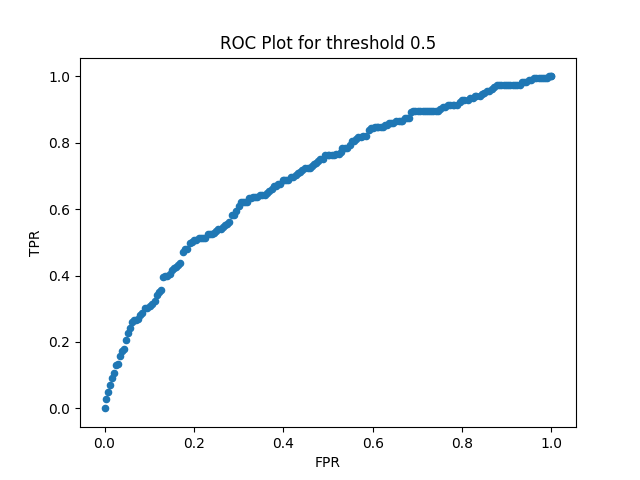

In [101]:

plt.figure(figsize=(12,12))
roc_df.plot(x='FPR', y='TPR', kind='scatter')
plt.title('ROC Plot for threshold 0.5')
plt.show()
%matplot plt

In [102]:
# AUC for default threshold 0.5
result_model2.areaUnderROC

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

0.7020662995367732

In [103]:
#Recall for default threshold 0.5
result_model2.recallByLabel

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

[1.0, 0.0]

In [104]:
if use_s3_to_save_checkpoints:
    result_model2.predictions.coalesce(1).write.option("header", 
                                            "true").parquet(s3_bucket_path +"LogReg_model2_1.parquet")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [105]:
if use_s3_to_load_checkpoints:
    
    result_model2= spark.read.parquet(s3_bucket_path + "LogReg_model2_1.parquet")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### Finding the right Threshold

In [106]:
# Extracting only the actual target and the predicted probabilities
preds_df = result_model2.predictions.select('target', 'probability')
preds_df.show(truncate=False)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------+------------------------------------------+
|target|probability                               |
+------+------------------------------------------+
|0     |[0.9919131811061853,0.00808681889381461]  |
|0     |[0.9932708086345123,0.006729191365487642] |
|0     |[0.9841526393919695,0.015847360608030527] |
|0     |[0.9694473296961233,0.030552670303876695] |
|0     |[0.9900018440800986,0.009998155919901362] |
|0     |[0.9978752954144182,0.0021247045855818246]|
|0     |[0.9918712078783276,0.008128792121672527] |
|0     |[0.9661634766224833,0.03383652337751677]  |
|0     |[0.9912169429279151,0.008783057072084845] |
|0     |[0.9862865577690869,0.013713442230912976] |
|0     |[0.97064063465873,0.029359365341270083]   |
|0     |[0.9584703678226392,0.04152963217736077]  |
|0     |[0.9899430731069019,0.010056926893098075] |
|0     |[0.9901247458394551,0.009875254160544958] |
|0     |[0.9772637761913298,0.022736223808670318] |
|0     |[0.969110824702692,0.030889175297307836]  |
|0     |[0.9

In [107]:
# Define a udf to extract the probability of getting target=1 from the model predicted probabilities
probability_extraction=udf(lambda x:float(x[1]),FloatType())


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [108]:
# During thhe first try, all thresholds above 0.2 was giving 0 precision and NaN recall,
# This is probably because of the imbalance in the target data
# Hence sticking to lower threshold values
threshold_list = [0.01, 0.02, 0.03, 0.04, 0.05, 0.07, 0.1, 0.2, 0.3]
result=[]

for threshold in threshold_list:
    new_pred = preds_df.withColumn('new_prediction', 
                              when(probability_extraction(
                                  preds_df['probability']) > threshold, 1).otherwise(0))
    TP = new_pred.filter('target==1 and new_prediction==1').count()
    TN = new_pred.filter('target==0 and new_prediction==0').count()
    FP = new_pred.filter('target==0 and new_prediction==1').count()
    FN = new_pred.filter('target==1 and new_prediction==0').count()
    if (TP + FP == 0):
        precision = float("nan")
    else:
        precision = TP/float(TP + FP)
    if TP + FN == 0:
        recall = float('nan')
    else:
        recall = TP/float(TP + FN)
        
    result.append([threshold, precision, recall, TP, TN, FP, FN])

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Exception in thread cell_monitor-107:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/opt/conda/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 178, in cell_monitor
    job_binned_stages[job_id][stage_id] = all_stages[stage_id]
KeyError: 1976



In [109]:
result_df = spark.createDataFrame(result,
                                  schema=StructType([StructField('threshold', FloatType(), True),
                                          StructField('precision', FloatType(), True),
                                          StructField('recall', FloatType(), True),
                                          StructField('TP', IntegerType(), True),
                                          StructField('TN', IntegerType(), True),
                                          StructField('FP', IntegerType(), True),
                                          StructField('FN', IntegerType(), True)])
                                 )
result_df.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---------+-----------+-----------+---+-----+----+---+
|threshold|  precision|     recall| TP|   TN|  FP| FN|
+---------+-----------+-----------+---+-----+----+---+
|     0.01| 0.02077337|  0.8972973|166| 2928|7825| 19|
|     0.02|0.033979136| 0.61621624|114| 7512|3241| 71|
|     0.03|0.051282052|  0.3027027| 56| 9717|1036|129|
|     0.04| 0.07417583| 0.14594595| 27|10416| 337|158|
|     0.05|0.083333336|0.075675674| 14|10599| 154|171|
|     0.07| 0.11111111|0.021621622|  4|10721|  32|181|
|      0.1|        0.0|        0.0|  0|10745|   8|185|
|      0.2|        NaN|        0.0|  0|10753|   0|185|
|      0.3|        NaN|        0.0|  0|10753|   0|185|
+---------+-----------+-----------+---+-----+----+---+

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

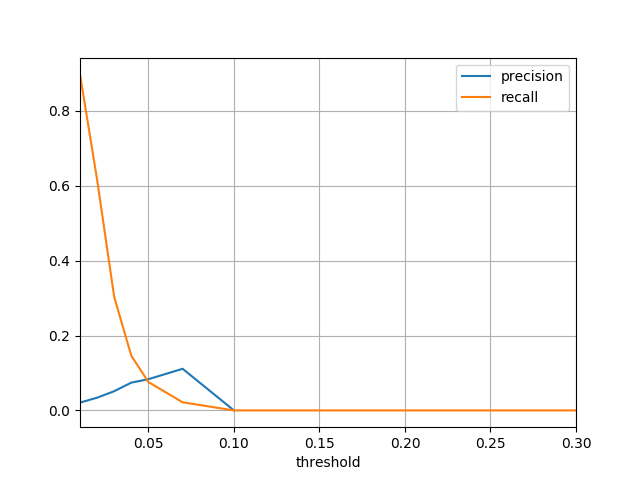

In [110]:
# Plotting the Precision-Recall curve to find the optimum threshold
result_df.toPandas().plot(x='threshold', y=['precision', 'recall'])
plt.grid()
plt.show()
%matplot plt

### With the above graph it looks like the precision and recall curves meet at a threshold of about 0.05

**However**

Since this is for Credit Risk application, and the bank is minimizing the risk of defaulters, a high recall is preferred. In other words, they should be able to predict defaulters (FN) by favouring a higher recall. <br>
With the current data, a **threshold of 0.01 seems to be the best**

### Evaluating the model using this threshold

In [134]:
threshold = 0.01
lr2 = LogisticRegression(featuresCol='features', labelCol='target', threshold=threshold)
model2 = lr2.fit(train_df)


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Exception in thread cell_monitor-133:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/opt/conda/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 178, in cell_monitor
    job_binned_stages[job_id][stage_id] = all_stages[stage_id]
KeyError: 4593



In [135]:
train_eval = model2.evaluate(train_df)
test_eval = model2.evaluate(test_df)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [136]:
print('Training Data Recall = ', train_eval.recallByLabel[1])
print('Testing Data Recall =', test_eval.recallByLabel[1])

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Training Data Recall =  0.877030162412993
Testing Data Recall = 0.8972972972972973

In [137]:
print('Training Data Precision =',train_eval.precisionByLabel[1])
print('Test Data Precision = ', test_eval.precisionByLabel[1])

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Training Data Precision = 0.020546828287220743
Test Data Precision =  0.02077337004129646

In [138]:
print('Training Data AUC = ', train_eval.areaUnderROC)
print('Testing Data AUC = ', test_eval.areaUnderROC)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Training Data AUC =  0.6594582891886455
Testing Data AUC =  0.7020662995367731

In [139]:
test_recall = test_eval.recallByLabel[1]
test_precision= test_eval.precisionByLabel[1]
test_f1 = 2 * (test_recall * test_precision)/(test_recall + test_precision)

train_recall = train_eval.recallByLabel[1]
train_precision = train_eval.precisionByLabel[1]
train_f1 = 2 * (train_recall * train_precision)/(train_recall + train_precision)

print('Training Data F1 Score =', train_f1)
print('Testing Data F1 Score =', test_f1)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Training Data F1 Score = 0.04015296367112811
Testing Data F1 Score = 0.04060665362035225

In [117]:
def get_confusion_matrix(model_result):
    preds = model_result.predictions.select('target', 'prediction')
    TP = preds.filter('target==1 and prediction==1').count()
    TN = preds.filter('target==0 and prediction==0').count()
    FP = preds.filter('target==0 and prediction==1').count()
    FN = preds.filter('target==1 and prediction==0').count()
    
    data = np.array([[TP, FN],
                    [FP, TN]])
    conf_matrix = pd.DataFrame(data=data,
                 index = ['True', 'False'],
                 columns = ['True', 'False']
                )
    return conf_matrix



VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [140]:
print('Confusion Matrix on Training Data:')
get_confusion_matrix(train_eval)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Exception in thread cell_monitor-137:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/opt/conda/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 178, in cell_monitor
    job_binned_stages[job_id][stage_id] = all_stages[stage_id]
KeyError: 4796



Confusion Matrix on Training Data:
        True  False
True     378     53
False  18019   7069

In [119]:
print('Confusion Matrix on Testing Data:')
get_confusion_matrix(test_eval)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Confusion Matrix on Testing Data:
       True  False
True     27    158
False   337  10416

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

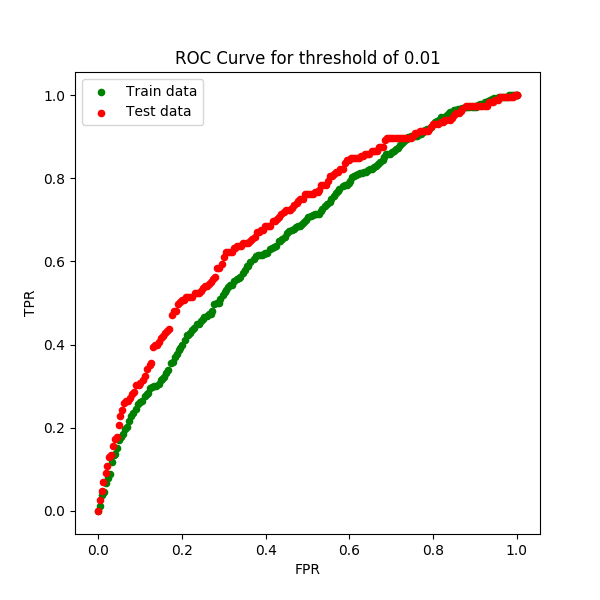

In [141]:
train_roc = train_eval.roc.toPandas()
test_roc = test_eval.roc.toPandas()
fig, ax = plt.subplots(1,1, figsize=(6,6))
train_roc.plot( x='FPR', y='TPR', kind='scatter', label='Train data', ax=ax, c='g')
test_roc.plot( x='FPR', y='TPR', kind='scatter', label='Test data', ax=ax, c= 'r')
plt.legend()
plt.title('ROC Curve for threshold of {:.2f}'.format(threshold))
plt.show()
%matplot plt

### Calculation of KS Statistics

In [121]:
def ks_calc(preds_df, targetCol='target', probCol='single_prob'):
    '''
    Function to calculate KS Statistic. Assumption is that targetCol has 0 and 1 as the binary values.
    preds_df: PySpark SQL DataFrame
    targetCol: string, default = 'target'. The column in preds_df that is the column for
        actual target labels
    probCol: string, default = 'single_prob'. The column in preds_df that is the column 
        containing
    '''
    #Sorting the table in descending predicted probability
    preds_df = preds_df.select(targetCol, probCol).sort(probCol, ascending=False)
    
    quantile_size = preds_df.count()//10

    print('Full data count = ', preds_df.count())
    print('Decile size = ', quantile_size)

#     total_defaulters = preds_df.filter(preds_df[targetCol]==1).count()
#     total_non_defaulters = preds_df.filter(preds_df[targetCol]==0).count()
    temp = preds_df.groupBy('target').count().toPandas()
    total_defaulters, total_non_defaulters = temp[temp[targetCol]==1]['count'].values[0],\
                                             temp[temp[targetCol]==0]['count'].values[0]
    print(f'Total Defaulters = {total_defaulters}, Total non-defaulters = {total_non_defaulters}')
    
    # Adding a sequence column
    preds_df = preds_df.withColumn('id', row_number().over(Window.orderBy(monotonically_increasing_id())))
    
    pointer = 0
    ks_result = []
    for i in range(0,10):
        if i < 9:
            # If there are more number of rows than the quantile size
            # Take those many rows
            temp_df = preds_df.filter('id < ' + str(quantile_size + pointer)) \
                                .filter('id >' + str(pointer)) \
                                .select(probCol, targetCol)
            # Moving the pointer for the next quantile 
            pointer += quantile_size
        else:
            # This may happen in the last iteration
            # So, taking all the columns above the pointer (lower limit)
            temp_df = preds_df.filter('id >' + str(pointer)) \
                                .select(probCol, targetCol)


        print(f'i={i}, pointer = {pointer} preds_df={preds_df.count()}, temp_df={temp_df.count()}')

        # Taking the metrics of the quantile
        #Quantile number
        index = i+1

        # Min and Max scores in the selected quantile
        temp_pd = temp_df.agg(F.max(temp_df[probCol]).alias('max_score'), 
         F.min(temp_df[probCol]).alias('min_score')).toPandas()
        min_score, max_score = temp_pd['min_score'].values[0], \
                                temp_pd['max_score'].values[0]
#         min_score = temp_df.agg({probCol:'min'}).collect()[0]['min('+ probCol +')'] # Min score of the quantile
#         max_score = temp_df.agg({probCol:'max'}).collect()[0]['max('+ probCol +')'] # Max score of the quantile
        print(f'min_score = {min_score}, \
              max_score ={max_score}')

        # Count of defaulters and non-defaulters
        temp_pd = temp_df.groupBy(targetCol).count().toPandas()
        defaulters, non_defaulters = temp_pd[temp_pd[targetCol]==1]['count'].values[0],\
                                     temp_pd[temp_pd[targetCol]==0]['count'].values[0]
#         defaulters = temp_df.filter(temp_df[targetCol] == 1).count() # Number of rows with target = 1
#         non_defaulters = temp_df.filter(temp_df[targetCol] == 0).count() # Number of rows with target = 0
        quantile_total = defaulters + non_defaulters 
        print(f'defaulters = {defaulters},  \
              non-defaulters = {non_defaulters}, \
              quantile_total={quantile_total}')

        # Calculating the cumulative percentages and KS
        cumulative_defaulters_pct = defaulters*100/float(total_defaulters) 
        cumulative_non_defaulters_pct = non_defaulters*100/float(total_non_defaulters)
        
        ks = abs(cumulative_non_defaulters_pct - cumulative_defaulters_pct)
        print(f'cumulative_defaulters = {cumulative_defaulters_pct}, \
              cumulative_non_defaulters_pct={cumulative_defaulters_pct}')

        # Adding the result to a list for further processing
        ks_result.append( [index, min_score, max_score, defaulters, non_defaulters, 
                           quantile_total, cumulative_defaulters_pct, 
                           cumulative_non_defaulters_pct, ks
                          ])
    
    # Create a dataframe using the ks_result list
    ks_df = pd.DataFrame(data=ks_result,
             columns=['decile', 'min_scr', 'max_scr',
                      'defaults', 'non_defaults', 'total',
                      'cumu_defaults %', 'cumu_non_defaults %',
                      'KS'
                     ]
            )
    ks_df['min_scr'] = ks_df['min_scr'].apply('{0:.4%}'.format)
    ks_df['max_scr'] = ks_df['max_scr'].apply('{0:.4%}'.format)
    ks_df['cumu_defaults %'] = ks_df['cumu_defaults %'].apply('{0:.2%}'.format)
    ks_df['cumu_non_defaults %'] = ks_df['cumu_non_defaults %'].apply('{0:.2%}'.format)
    ks_df.set_index('decile', inplace=True)

    return ks_df, ks_df['KS'].max()


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [122]:
pd.set_option('display.max_columns', 9)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Calculating KS Statistic for Training Data

In [142]:
preds_df = train_eval.predictions.select('target', 'probability')
# Since probability coluum has arrays, splitting this and taking only the probability of 1 into account
preds_df = preds_df.withColumn('single_prob', 
                    probability_extraction(preds_df['probability'])
                   )
#Sorting the table in descending predicted probability
preds_df = preds_df.select('target', 'single_prob').sort('single_prob', ascending=False)

preds_df.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------+-----------+
|target|single_prob|
+------+-----------+
|     0| 0.11871734|
|     0| 0.11871734|
|     0| 0.11871734|
|     0|0.116023794|
|     0| 0.11395987|
+------+-----------+
only showing top 5 rows

In [143]:
ks_df, ks = ks_calc(preds_df, targetCol='target', probCol='single_prob')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Exception in thread cell_monitor-142:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/opt/conda/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 178, in cell_monitor
    job_binned_stages[job_id][stage_id] = all_stages[stage_id]
KeyError: 4890



Full data count =  25519
Decile size =  2551
Total Defaulters = 431, Total non-defaulters = 25088
i=0, pointer = 2551 preds_df=25519, temp_df=2550
min_score = 0.02965153567492962,               max_score =0.11871734261512756
defaulters = 111,                non-defaulters = 2439,               quantile_total=2550
cumulative_defaulters = 25.754060324825986,               cumulative_non_defaulters_pct=25.754060324825986
i=1, pointer = 5102 preds_df=25519, temp_df=2550
min_score = 0.02381890080869198,               max_score =0.029650360345840454
defaulters = 59,                non-defaulters = 2491,               quantile_total=2550
cumulative_defaulters = 13.689095127610209,               cumulative_non_defaulters_pct=13.689095127610209
i=2, pointer = 7653 preds_df=25519, temp_df=2550
min_score = 0.020012442022562027,               max_score =0.023818692192435265
defaulters = 53,                non-defaulters = 2497,               quantile_total=2550
cumulative_defaulters = 12.296983758

In [144]:
print('KS Statistics data from Training data ')
ks_df

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

KS Statistics data from Training data 
        min_scr   max_scr  defaults  non_defaults  total cumu_defaults %  \
decile                                                                     
1       2.9652%  11.8717%       111          2439   2550        2575.41%   
2       2.3819%   2.9650%        59          2491   2550        1368.91%   
3       2.0012%   2.3819%        53          2497   2550        1229.70%   
4       1.7172%   2.0006%        44          2506   2550        1020.88%   
5       1.4924%   1.7168%        35          2515   2550         812.06%   
6       1.2722%   1.4922%        36          2514   2550         835.27%   
7       1.0454%   1.2721%        32          2518   2550         742.46%   
8       0.8304%   1.0453%        30          2520   2550         696.06%   
9       0.6296%   0.8304%        19          2531   2550         440.84%   
10      0.1060%   0.6296%        12          2548   2560         278.42%   

       cumu_non_defaults %         KS  
decile  

In [145]:
print('KS Statistic from the Training data = ', ks)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

KS Statistic from the Training data =  16.032280988091294

Calculating KS Statistic for Testing Data

In [146]:
preds_df = test_eval.predictions.select('target', 'probability')
# Since probability coluum has arrays, splitting this and taking only the probability of 1 into account
preds_df = preds_df.withColumn('single_prob', 
                    probability_extraction(preds_df['probability'])
                   )
#Sorting the table in descending predicted probability
preds_df = preds_df.select('target', 'single_prob').sort('single_prob', ascending=False)

preds_df.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------+-----------+
|target|single_prob|
+------+-----------+
|     0| 0.11871734|
|     0| 0.11871734|
|     0|  0.1147694|
|     0|  0.1147694|
|     0| 0.11233624|
+------+-----------+
only showing top 5 rows

In [147]:
ks_df, ks = ks_calc(preds_df, targetCol='target', probCol='single_prob')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Exception in thread cell_monitor-146:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/opt/conda/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 178, in cell_monitor
    job_binned_stages[job_id][stage_id] = all_stages[stage_id]
KeyError: 5793



Full data count =  10938
Decile size =  1093
Total Defaulters = 185, Total non-defaulters = 10753
i=0, pointer = 1093 preds_df=10938, temp_df=1092
min_score = 0.030005237087607384,               max_score =0.11871734261512756
defaulters = 56,                non-defaulters = 1036,               quantile_total=1092
cumulative_defaulters = 30.27027027027027,               cumulative_non_defaulters_pct=30.27027027027027
i=1, pointer = 2186 preds_df=10938, temp_df=1092
min_score = 0.023947151377797127,               max_score =0.029997317120432854
defaulters = 37,                non-defaulters = 1055,               quantile_total=1092
cumulative_defaulters = 20.0,               cumulative_non_defaulters_pct=20.0
i=2, pointer = 3279 preds_df=10938, temp_df=1092
min_score = 0.020191069692373276,               max_score =0.02394290268421173
defaulters = 17,                non-defaulters = 1075,               quantile_total=1092
cumulative_defaulters = 9.18918918918919,               cumulative

In [148]:
print('KS Statistics data from Testing data ')
ks_df

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

KS Statistics data from Testing data 
        min_scr   max_scr  defaults  non_defaults  total cumu_defaults %  \
decile                                                                     
1       3.0005%  11.8717%        56          1036   1092        3027.03%   
2       2.3947%   2.9997%        37          1055   1092        2000.00%   
3       2.0191%   2.3943%        17          1075   1092         918.92%   
4       1.7418%   2.0189%        16          1076   1092         864.86%   
5       1.5063%   1.7408%        15          1077   1092         810.81%   
6       1.2852%   1.5062%        15          1077   1092         810.81%   
7       1.0653%   1.2844%        10          1082   1092         540.54%   
8       0.8565%   1.0645%         5          1087   1092         270.27%   
9       0.6340%   0.8561%         9          1083   1092         486.49%   
10      0.1130%   0.6335%         5          1096   1101         270.27%   

       cumu_non_defaults %         KS  
decile   

In [149]:
print('KS Statistic from the Testing data = ', ks)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

KS Statistic from the Testing data =  20.635749671367638

In [150]:
plt.close('all')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [132]:
# train_eval.predictions.coalesce(1).write.option("header", 
#                                             "true").parquet(s3_bucket_path +"train_eval_data.parquet")
# test_eval.predictions.coalesce(1).write.option("header", 
#                                             "true").parquet(s3_bucket_path +"test_eval_data.parquet")



VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [133]:
# encoded_df.coalesce(1).write.option("header", 
#                                             "true").parquet(s3_bucket_path +"encoded_df_before_model.parquet")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…